# MLB DFS Capstone - Feature Engineering
Any code not preceded by a markdown cell has been seen before. We'll still have markdown headings to indicate main turning points, but to streamline the process only code that is new to this stage of the project will be explained with text in a markdown cell. Code that's been seen before will be commented for reference.

In [733]:
#Imports
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing 
import warnings # For handling error messages. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [734]:
#Reading in CSVs of each player's stats from last 30 days (FGBatters_L30) 
#and his live stats on current date (FGBattersFP)
list_of_dfs = []
date_of_games = pd.to_datetime('20210427', format = '%Y%m%d')
for i in range(121, 245, 4):
    date_of_games = date_of_games + datetime.timedelta(days = 4)
    if i == 193:
        continue
    L30_df = pd.read_csv("FGBatters_L30_" + str(i) + "_all.csv")
    L30_df.drop(columns = ['Team', 'playerid'], inplace = True)
    games_df = pd.read_csv("FGBattersFP_" + str(i) + ".csv")
    games_df = games_df[games_df['PA'] > 0]
    games_df.rename(columns = {'PA':'PA_Game'}, inplace = True)
    new_df = pd.merge(games_df, L30_df, how = 'left', on = 'Name')
    new_df.insert(0, 'Date', date_of_games)
    list_of_dfs.append(new_df)

In [735]:
#Creating our main dataframe by vertically concatenating the list of dataframes we created in previous cell.
main_df = pd.concat(list_of_dfs, ignore_index = True)

In [736]:
main_df.head()

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,Contact%,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%
0,2021-05-01,Jurickson Profar,SDP,1,0,0,0,1,1,1,...,81.1%,45.9%,61.0%,8.1%,20.8%,51.4%,27.8%,36.1%,31.9%,31.9%
1,2021-05-01,Justin Williams,STL,1,0,0,0,1,2,1,...,67.0%,37.9%,53.9%,13.6%,13.2%,50.0%,36.8%,28.9%,47.4%,23.7%
2,2021-05-01,Andy Young,ARI,1,0,0,0,1,1,1,...,35.7%,32.7%,50.0%,18.4%,33.3%,0.0%,66.7%,0.0%,33.3%,66.7%
3,2021-05-01,Jared Walsh,LAA,5,2,0,0,2,3,2,...,79.5%,37.9%,46.2%,9.5%,31.3%,39.1%,29.7%,43.8%,35.9%,20.3%
4,2021-05-01,David Peralta,ARI,1,0,1,0,0,0,0,...,80.2%,43.8%,51.9%,8.9%,13.4%,52.4%,34.1%,31.7%,41.5%,26.8%


In [737]:
main_df.tail()

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,Contact%,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%
8426,2021-08-29,Lars Nootbaar,STL,1,0,0,0,0,0,0,...,83.8%,43.1%,59.2%,6.1%,15.2%,57.6%,27.3%,33.3%,39.4%,27.3%
8427,2021-08-29,Cal Raleigh,SEA,3,0,0,0,0,0,0,...,65.1%,45.8%,72.7%,21.1%,20.5%,66.7%,12.8%,43.6%,30.8%,25.6%
8428,2021-08-29,Ryan Jeffers,MIN,4,0,0,0,0,0,0,...,74.0%,37.6%,59.7%,13.1%,20.6%,38.2%,41.2%,44.1%,44.1%,11.8%
8429,2021-08-29,Sam Long,SFG,2,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8430,2021-08-29,Kwang-hyun Kim,STL,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [738]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8431 entries, 0 to 8430
Data columns (total 57 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        8431 non-null   datetime64[ns]
 1   Name        8431 non-null   object        
 2   Team        8431 non-null   object        
 3   PA_Game     8431 non-null   int64         
 4   1B          8431 non-null   int64         
 5   2B          8431 non-null   int64         
 6   3B          8431 non-null   int64         
 7   HR          8431 non-null   int64         
 8   RBI         8431 non-null   int64         
 9   R           8431 non-null   int64         
 10  BB          8431 non-null   int64         
 11  SB          8431 non-null   int64         
 12  HBP         8431 non-null   int64         
 13  playerid    8431 non-null   int64         
 14  PA          7859 non-null   float64       
 15  Events      7859 non-null   float64       
 16  EV          7844 non-nul

In [739]:
main_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PA_Game,8431.0,3.596845,1.365334,1.0,3.000,4.000,4.000,9.000
1B,8431.0,0.500297,0.689331,0.0,0.000,0.000,1.000,4.000
2B,8431.0,0.154786,0.395857,0.0,0.000,0.000,0.000,3.000
3B,8431.0,0.011505,0.107756,0.0,0.000,0.000,0.000,2.000
HR,8431.0,0.116000,0.345545,0.0,0.000,0.000,0.000,3.000
RBI,8431.0,0.416321,0.828232,0.0,0.000,0.000,1.000,7.000
R,8431.0,0.435891,0.674137,0.0,0.000,0.000,1.000,5.000
BB,8431.0,0.312181,0.564714,0.0,0.000,0.000,1.000,4.000
SB,8431.0,0.039972,0.207662,0.0,0.000,0.000,0.000,3.000
HBP,8431.0,0.043530,0.209791,0.0,0.000,0.000,0.000,2.000


In [740]:
#Dropping rows where plate appearances in that day's game are less than 3.
#If a player didn't appear at the plate at least three times there's a good chance he didn't start the game.
#A DFS player wouldn't knowingly roster a player who isn't starting.

main_df = main_df[main_df['PA_Game'] >= 3]

In [741]:
main_df.reset_index(drop=True, inplace=True)

In [742]:
main_df.head()

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,Contact%,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%
0,2021-05-01,Jared Walsh,LAA,5,2,0,0,2,3,2,...,79.5%,37.9%,46.2%,9.5%,31.3%,39.1%,29.7%,43.8%,35.9%,20.3%
1,2021-05-01,Andrew Benintendi,KCR,4,1,0,0,2,2,3,...,76.3%,43.4%,57.8%,11.4%,13.3%,60.0%,26.7%,35.0%,30.0%,35.0%
2,2021-05-01,Salvador Perez,KCR,3,0,1,0,1,3,2,...,67.1%,35.1%,67.6%,19.1%,20.3%,40.6%,39.1%,42.0%,31.9%,26.1%
3,2021-05-01,Willie Calhoun,TEX,4,1,1,0,1,2,2,...,83.1%,37.0%,55.6%,6.5%,20.6%,47.1%,32.4%,35.3%,35.3%,29.4%
4,2021-05-01,Jeimer Candelario,DET,4,2,0,0,1,1,1,...,77.7%,43.8%,76.1%,11.4%,23.0%,54.1%,23.0%,33.8%,37.8%,28.4%


In [743]:
main_df.shape

(6728, 57)

In [744]:
#Dropping doubleheaders
doubleheader_dict = {'20210505': ['NYM', 'STL'], '20210529': ['COL', 'PIT', 'MIL', 'WSN', 'BAL', 'CHW'], \
                     '20210626': ['HOU', 'DET'], '20210630': ['DET', 'CLE'], '20210704': ['NYY', 'NYM'], \
                     '20210716': ['MIA', 'PHI'], '20210728': ['TOR', 'BOS'], '20210817': ['BOS', 'NYY'], \
                    '20210825': ['COL', 'CHC'], }

In [745]:
for key, value in doubleheader_dict.items():
    temp_date = pd.to_datetime(key, format = '%Y%m%d')
    main_df = main_df.loc[~((main_df['Date'] == temp_date) & (main_df['Team'].isin(value))), :]

In [746]:
main_df.shape

(6487, 57)

In [747]:
#Calculating target variables. First FanDuel points, then DraftKings points
main_df['FD_Pts'] = (main_df['1B'] * 3) + (main_df['2B'] * 6) + (main_df['3B'] * 9) + (main_df['HR'] * 12) \
+ (main_df['RBI'] * 3.5) + (main_df['R'] * 3.2) + (main_df['BB'] * 3) + (main_df['SB'] * 6) + (main_df['HBP'] * 3) 

In [748]:
main_df['DK_Pts'] = (main_df['1B'] * 3) + (main_df['2B'] * 5) + (main_df['3B'] * 8) + (main_df['HR'] * 10) \
+ (main_df['RBI'] * 2) + (main_df['R'] * 2) + (main_df['BB'] * 2) + (main_df['SB'] * 5) + (main_df['HBP'] * 2) 

In [749]:
main_df.head()

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%,FD_Pts,DK_Pts
0,2021-05-01,Jared Walsh,LAA,5,2,0,0,2,3,2,...,46.2%,9.5%,31.3%,39.1%,29.7%,43.8%,35.9%,20.3%,49.9,38
1,2021-05-01,Andrew Benintendi,KCR,4,1,0,0,2,2,3,...,57.8%,11.4%,13.3%,60.0%,26.7%,35.0%,30.0%,35.0%,43.6,33
2,2021-05-01,Salvador Perez,KCR,3,0,1,0,1,3,2,...,67.6%,19.1%,20.3%,40.6%,39.1%,42.0%,31.9%,26.1%,34.9,25
3,2021-05-01,Willie Calhoun,TEX,4,1,1,0,1,2,2,...,55.6%,6.5%,20.6%,47.1%,32.4%,35.3%,35.3%,29.4%,34.4,26
4,2021-05-01,Jeimer Candelario,DET,4,2,0,0,1,1,1,...,76.1%,11.4%,23.0%,54.1%,23.0%,33.8%,37.8%,28.4%,24.7,20


# Dropping columns used to calculate target variables
Now that we have FanDuel points and DraftKings points calculated, there's really no need to lug the following columns through the rest of the project. They are used to calculate the player's fantasy points in that day's game and have no predictive use. Neither do that day's number of plate appearances ('PA_Game') and playerid.

In [750]:
main_df.drop(columns = ['PA_Game', '1B', '2B', '3B', 'HR', 'RBI', 'R', 'BB', 'SB', 'HBP', 'playerid'], inplace = True)

In [751]:
main_df.shape

(6487, 48)

In [752]:
#Reading in CSV of (hopefully) everyone who has pitched in 2021 so we can weed pitchers out of the batting statistics.
#Pitchers did bat in the National League through 2021, but were not available to be drafted as hitters.
pitchers = pd.read_csv('FG_Pitcher_Names_2021.csv')

In [753]:
pitchers.head()

,Name,Team,W,L,SV,G,GS,IP,K/9,BB/9,...,LOB%,GB%,HR/FB,vFA (pi),ERA,xERA,FIP,xFIP,WAR,playerid
0,Corbin Burnes,MIL,11,5,0,28,28,167.0,12.61,1.83,...,75.7%,48.8%,6.1%,96.5,2.43,2.01,1.63,2.30,7.5,19361
1,Zack Wheeler,PHI,14,10,0,32,32,213.1,10.42,1.94,...,75.3%,49.8%,10.8%,97.3,2.78,2.78,2.59,2.84,7.3,10310
2,Nathan Eovaldi,BOS,11,9,0,32,32,182.1,9.63,1.73,...,70.4%,42.0%,8.2%,97.1,3.75,3.37,2.79,3.48,5.6,9132
3,Walker Buehler,LAD,16,4,0,33,33,207.2,9.19,2.25,...,80.9%,44.7%,10.1%,95.5,2.47,3.08,3.15,3.57,5.5,19374
4,Max Scherzer,- - -,15,4,0,30,30,179.1,11.84,1.81,...,84.3%,33.5%,11.7%,94.5,2.46,2.89,2.97,3.24,5.4,3137


In [754]:
pitchers_names = list(pitchers['Name'])

In [755]:
for i in range(len(pitchers_names)):
    main_df = main_df.loc[main_df['Name'] != pitchers_names[i], :]
    

In [756]:
main_df.shape

(5905, 48)

In [757]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5905 entries, 0 to 6727
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5905 non-null   datetime64[ns]
 1   Name        5905 non-null   object        
 2   Team        5905 non-null   object        
 3   PA          5838 non-null   float64       
 4   Events      5838 non-null   float64       
 5   EV          5835 non-null   float64       
 6   maxEV       5835 non-null   float64       
 7   LA          5835 non-null   float64       
 8   Barrels     5837 non-null   float64       
 9   Barrel%     5835 non-null   object        
 10  HardHit     5837 non-null   float64       
 11  HardHit%    5835 non-null   object        
 12  AVG         5838 non-null   float64       
 13  SLG         5838 non-null   float64       
 14  wOBA        5838 non-null   float64       
 15  ISO         5838 non-null   float64       
 16  BABIP       5838 non-nul

In [758]:
#Assessing missing values. We'll end up dropping 87 rows.
main_df_with_nulls = main_df[main_df.isna().any(axis=1)]

In [759]:
main_df_with_nulls.head()

,Date,Name,Team,PA,Events,EV,maxEV,LA,Barrels,Barrel%,...,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%,FD_Pts,DK_Pts
124,2021-05-01,Yu-Cheng Chang,CLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,7
234,2021-05-01,Austin Nola,SDP,1.0,1.0,95.3,95.3,27.7,0.0,0.0%,...,NaN,0.0%,0.0%,0.0%,100.0%,0.0%,0.0%,100.0%,0.0,0
247,2021-05-01,Daniel Johnson Jr.,CLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
372,2021-05-05,Hunter Owen,PIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2
374,2021-05-05,Reese McGuire,TOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2


In [760]:
main_df_with_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 124 to 6725
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        87 non-null     datetime64[ns]
 1   Name        87 non-null     object        
 2   Team        87 non-null     object        
 3   PA          20 non-null     float64       
 4   Events      20 non-null     float64       
 5   EV          17 non-null     float64       
 6   maxEV       17 non-null     float64       
 7   LA          17 non-null     float64       
 8   Barrels     19 non-null     float64       
 9   Barrel%     17 non-null     object        
 10  HardHit     19 non-null     float64       
 11  HardHit%    17 non-null     object        
 12  AVG         20 non-null     float64       
 13  SLG         20 non-null     float64       
 14  wOBA        20 non-null     float64       
 15  ISO         20 non-null     float64       
 16  BABIP       20 non-null 

In [761]:
main_df.isnull().sum().sum()

2951

In [762]:
main_df.dropna(inplace=True)
main_df.reset_index(drop=True, inplace = True)

In [763]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5818 entries, 0 to 5817
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5818 non-null   datetime64[ns]
 1   Name        5818 non-null   object        
 2   Team        5818 non-null   object        
 3   PA          5818 non-null   float64       
 4   Events      5818 non-null   float64       
 5   EV          5818 non-null   float64       
 6   maxEV       5818 non-null   float64       
 7   LA          5818 non-null   float64       
 8   Barrels     5818 non-null   float64       
 9   Barrel%     5818 non-null   object        
 10  HardHit     5818 non-null   float64       
 11  HardHit%    5818 non-null   object        
 12  AVG         5818 non-null   float64       
 13  SLG         5818 non-null   float64       
 14  wOBA        5818 non-null   float64       
 15  ISO         5818 non-null   float64       
 16  BABIP       5818 non-nul

In [764]:
print(all(main_df))

True


# Handedness

In [765]:
#Reading in dataframes that break down handedness matchups,
#extracting the names and turning them into sets of left-handed and right-handed batters
#so we can distinguish between right-handed hitters, left-handed hitters and switch-hitters
rhh_df = pd.read_csv("FGBatters_vsLasR.csv")
lhh_df = pd.read_csv("FGBatters_vsRasL.csv")

In [766]:
rhh_df = rhh_df[['Name']]
lhh_df = lhh_df[['Name']]

In [767]:
righties_set = set(rhh_df['Name'])
lefties_set = set(lhh_df['Name'])

In [768]:
righties_only = list(righties_set.difference(lefties_set))
lefties_only = list(lefties_set.difference(righties_set))
switch = list(righties_set.intersection(lefties_set))

In [769]:
conds = [main_df['Name'].isin(righties_only), main_df['Name'].isin(lefties_only), main_df['Name'].isin(switch)]
choices = ['R', 'L', 'S']

In [770]:
#Adding 'Bats' categorical variable
main_df['Bats'] = np.select(conds, choices)

In [771]:
main_df['Bats'].unique()

array(['L', 'R', 'S', '0'], dtype=object)

In [772]:
missing_bat_hand = main_df[main_df['Bats'] == '0']

In [773]:
#We have 85 rows (45 unique players) with a '0' value for bat hand.
#Using Baseball Reference, we find the missing values
missing_bat_hand['Name'].unique()

array(['Cristian Pache', 'Chad Wallach', 'Tony Wolters', 'Aramis Garcia',
       'Grayson Greiner', 'Nick Senzel', 'Alan Trejo', 'Todd Frazier',
       'Drew Butera', 'Jeff Mathis', 'Johneshwy Fargas',
       'Jacob Nottingham', 'Cameron Maybin', 'Will Craig', 'Max Moroff',
       'P.J. Higgins', 'Eric Campbell', 'Webster Rivas', 'Mason Williams',
       'Chris Gittens', 'Ryan Lavarnway', 'Steven Souza Jr.',
       'Jake Burger', 'Sebastian Rivero', 'Jared Oliva', 'Orlando Arcia',
       'Chris Owings', 'Tres Barrera', 'Vidal Brujan', 'Stuart Fairchild',
       'Estevan Florial', 'Rob Brantly', 'Curtis Terry', 'Adrian Sanchez',
       'Matt Thaiss', 'Jake Hager', 'Jacob Wilson', 'Austin Romine',
       'Renato Nunez', 'Yohel Pozo', 'Michael Hermosillo',
       'Dustin Garneau', 'Jahmai Jones', 'Kevin Smith', 'Jorge Bonifacio'],
      dtype=object)

In [774]:
len(missing_bat_hand)

85

In [775]:
len(missing_bat_hand['Name'].unique())

45

In [776]:
#Creating lists for left-handed hitters and switch-hitters. The rest of the hitters are right-handed.
missing_lefties = ['Tony Wolters', 'Mason Williams', 'Estevan Florial', 'Rob Brantly', 'Matt Thaiss', 'Austin Allen']
missing_switch = ['Max Moroff', 'Vidal Brujan', 'Taylor Gushue']

In [777]:
main_df.columns.get_loc('Name')

1

In [778]:
main_df.columns.get_loc('Bats')

48

In [779]:
for i in range(len(main_df)):
    if main_df.iloc[i, 48] == '0':
        if main_df.iloc[i, 1] in missing_lefties:
            main_df.iloc[i, 48] = 'L'
        elif main_df.iloc[i, 1] in missing_switch:
            main_df.iloc[i, 48] = 'S'
        else:
            main_df.iloc[i, 48] = 'R'

In [780]:
main_df['Bats'].unique()

array(['L', 'R', 'S'], dtype=object)

# Bringing in the Odds dataframe

In [781]:
odds_df = pd.read_excel("MLBOdds_1005.xlt")

In [782]:
odds_df.head()

,Date,VH,Team,Pitcher,Open,OpenOU
0,501,V,MIA,PCAMPBELL,105,8.5
1,501,H,WAS,PCORBIN-L,-125,8.5
2,501,V,CUB,ZDAVIES,135,9.0
3,501,H,CIN,LCASTILLO,-160,9.0
4,501,V,NYM,TWALKER,100,7.5


In [783]:
odds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     766 non-null    int64  
 1   VH       766 non-null    object 
 2   Team     766 non-null    object 
 3   Pitcher  766 non-null    object 
 4   Open     766 non-null    int64  
 5   OpenOU   766 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 36.0+ KB


In [784]:
team_codes = main_df['Team'].unique()

In [785]:
team_codes

array(['LAA', 'KCR', 'TEX', 'DET', 'ARI', 'PHI', 'CHC', 'STL', 'NYM',
       'ATL', 'COL', 'TOR', 'LAD', 'WSN', 'BOS', 'OAK', 'MIL', 'SEA',
       'CHW', 'MIA', 'CLE', 'PIT', 'NYY', 'CIN', 'SDP', 'MIN', 'SFG',
       'BAL', 'HOU', 'TBR'], dtype=object)

In [786]:
#Creating a dict by hand so that three-letter team codes in Odds match up with the ones in main_df
odds_team_dict = {'SDG':'SDP', 'CWS':'CHW', 'SFO':'SFG', 'KAN':'KCR', 'WAS': 'WSN', 'TAM': 'TBR', 'CUB': 'CHC'}

In [787]:
odds_df['Team'].replace(odds_team_dict, inplace = True)

In [788]:
odds_df.head(10)

,Date,VH,Team,Pitcher,Open,OpenOU
0,501,V,MIA,PCAMPBELL,105,8.5
1,501,H,WSN,PCORBIN-L,-125,8.5
2,501,V,CHC,ZDAVIES,135,9.0
3,501,H,CIN,LCASTILLO,-160,9.0
4,501,V,NYM,TWALKER,100,7.5
5,501,H,PHI,ZWHEELER,-120,7.5
6,501,V,STL,JFLAHERTY,-135,7.5
7,501,H,PIT,TCAHILL,115,7.5
8,501,V,LAD,DMAY,-115,7.0
9,501,H,MIL,BWOODRUFF,-105,7.0


In [789]:
#There's one game missing from odd_df. We found the info somewhere else.
newrow1 = {'Date': 626, 'VH':'V', 'Team': 'SEA', 'Pitcher': 'GILBERT', 'Open': 165, 'OpenOU': 8.0}

In [790]:
newrow2 = {'Date': 626, 'VH':'H', 'Team': 'CHW', 'Pitcher': 'LYNN', 'Open': -195, 'OpenOU': 8.0}

In [791]:
odds_df = odds_df.append([newrow1], ignore_index = True)

In [792]:
odds_df = odds_df.append([newrow2], ignore_index = True)

In [793]:
odds_df.tail()

,Date,VH,Team,Pitcher,Open,OpenOU
763,829,H,CHW,DCEASE,-210,8.5
764,829,V,MIL,AASHBY-L,-140,10.0
765,829,H,MIN,GJAX,120,10.0
766,626,V,SEA,GILBERT,165,8.0
767,626,H,CHW,LYNN,-195,8.0


In [794]:
#Making sure all visiting teams are in even-indexed rows and all home teams are in odd-indexed rows.
odds_df.iloc[0::2, 1].unique()

array(['V'], dtype=object)

In [795]:
odds_df.iloc[1::2, 1].unique()

array(['H'], dtype=object)

In [796]:
odds_df.drop(columns = 'VH', inplace = True)

In [797]:
#Function to create separate odds dataframes for home and visiting teams
def split_odds_df(first_row, first_col, last_col):
    """Splitting odds_df by home and visiting teams"""
    odds_df_split = odds_df.iloc[first_row::2, first_col:last_col]
    odds_df_split.reset_index(drop = True, inplace = True)
    return odds_df_split

In [798]:
odds_df_v = split_odds_df(0, 0, -1)

In [799]:
odds_df_v.head()

,Date,Team,Pitcher,Open
0,501,MIA,PCAMPBELL,105
1,501,CHC,ZDAVIES,135
2,501,NYM,TWALKER,100
3,501,STL,JFLAHERTY,-135
4,501,LAD,DMAY,-115


In [800]:
#Adding V_ prefixes
odds_df_v.rename(columns = {'Team': 'V_Team', 'Pitcher': 'V_Pitcher', 'Open': 'V_Open'}, inplace = True)

In [801]:
odds_df_v.head()

,Date,V_Team,V_Pitcher,V_Open
0,501,MIA,PCAMPBELL,105
1,501,CHC,ZDAVIES,135
2,501,NYM,TWALKER,100
3,501,STL,JFLAHERTY,-135
4,501,LAD,DMAY,-115


In [802]:
odds_df_h = split_odds_df(1, 1, 5)

In [803]:
odds_df_h.head()

,Team,Pitcher,Open,OpenOU
0,WSN,PCORBIN-L,-125,8.5
1,CIN,LCASTILLO,-160,9.0
2,PHI,ZWHEELER,-120,7.5
3,PIT,TCAHILL,115,7.5
4,MIL,BWOODRUFF,-105,7.0


In [804]:
#Adding H_ prefixes
odds_df_h.rename(columns = {'Team':'H_Team', 'Pitcher':'H_Pitcher', 'Open': 'H_Open'}, inplace = True)

In [805]:
odds_df_h.head()

,H_Team,H_Pitcher,H_Open,OpenOU
0,WSN,PCORBIN-L,-125,8.5
1,CIN,LCASTILLO,-160,9.0
2,PHI,ZWHEELER,-120,7.5
3,PIT,TCAHILL,115,7.5
4,MIL,BWOODRUFF,-105,7.0


In [806]:
odds_df_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       384 non-null    int64 
 1   V_Team     384 non-null    object
 2   V_Pitcher  384 non-null    object
 3   V_Open     384 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 12.1+ KB


In [807]:
odds_df_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   H_Team     384 non-null    object 
 1   H_Pitcher  384 non-null    object 
 2   H_Open     384 non-null    int64  
 3   OpenOU     384 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 12.1+ KB


In [808]:
#Joining the dataframes we just created 
#so that now we have a single row for every game, with info for both visiting and home teams.
odds_df_all = odds_df_v.join(odds_df_h, how = 'left')

In [809]:
odds_df_all.head(10)

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU
0,501,MIA,PCAMPBELL,105,WSN,PCORBIN-L,-125,8.5
1,501,CHC,ZDAVIES,135,CIN,LCASTILLO,-160,9.0
2,501,NYM,TWALKER,100,PHI,ZWHEELER,-120,7.5
3,501,STL,JFLAHERTY,-135,PIT,TCAHILL,115,7.5
4,501,LAD,DMAY,-115,MIL,BWOODRUFF,-105,7.0
5,501,COL,AGOMBER-L,150,ARI,ZGALLEN,-180,8.0
6,501,SFG,ADESCLAFA,145,SDP,BSNELL-L,-170,7.0
7,501,DET,STURNBULL,175,NYY,JTAILLON,-210,8.0
8,501,KCR,DDUFFY-L,-105,MIN,MSHOEMAKE,-115,9.0
9,501,CLE,TMCKENZIE,145,CHW,LLYNN,-170,8.5


In [810]:
#Adding win probability columns and setting to 0.5. Will be adjusted according to money lines.
odds_df_all['V_Win_Prob'] = .5
odds_df_all['H_Win_Prob'] = .5

In [811]:
odds_df_all.head()

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob
0,501,MIA,PCAMPBELL,105,WSN,PCORBIN-L,-125,8.5,0.5,0.5
1,501,CHC,ZDAVIES,135,CIN,LCASTILLO,-160,9.0,0.5,0.5
2,501,NYM,TWALKER,100,PHI,ZWHEELER,-120,7.5,0.5,0.5
3,501,STL,JFLAHERTY,-135,PIT,TCAHILL,115,7.5,0.5,0.5
4,501,LAD,DMAY,-115,MIL,BWOODRUFF,-105,7.0,0.5,0.5


In [812]:
def create_win_prob(df, col1, col2):
    """Algorithm to process money lines"""
    for i in range(len(df)):
        moneyline = df.iloc[i, col1]
        overunder = df.iloc[i, 7]
        if moneyline < -300:
            df.iloc[i, col2] = .75
        elif moneyline > 300:
            df.iloc[i, col2] = .25
        else:
            if moneyline < 0:
                moneyline = moneyline + 100
            else:
                moneyline = moneyline - 100
            moneyline = moneyline + 200
            win_prob = .75 - moneyline * .00125
            df.iloc[i, col2] = win_prob

In [813]:
create_win_prob(odds_df_all, 3, 8)
create_win_prob(odds_df_all, 6, 9)
#create_proj_runs(odds_df_all, 3, 8)
#create_proj_runs(odds_df_all, 6, 9)

In [814]:
#Adding a prob_total column to make sure our win probabilities add up to 1
odds_df_all['prob_total'] = odds_df_all['V_Win_Prob'] + odds_df_all['H_Win_Prob']

In [815]:
odds_df_all.head()

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob,prob_total
0,501,MIA,PCAMPBELL,105,WSN,PCORBIN-L,-125,8.5,0.49375,0.53125,1.02500
1,501,CHC,ZDAVIES,135,CIN,LCASTILLO,-160,9.0,0.45625,0.57500,1.03125
2,501,NYM,TWALKER,100,PHI,ZWHEELER,-120,7.5,0.50000,0.52500,1.02500
3,501,STL,JFLAHERTY,-135,PIT,TCAHILL,115,7.5,0.54375,0.48125,1.02500
4,501,LAD,DMAY,-115,MIL,BWOODRUFF,-105,7.0,0.51875,0.50625,1.02500


In [816]:
#Since most of these win probabilities add up to a number greater than 1,
#we take the overset, split it and subtract equally from both H_Win_Prob and V_Win_Prob
odds_df_all['prob_overset'] = odds_df_all['V_Win_Prob'] + odds_df_all['H_Win_Prob'] - 1
odds_df_all['V_Win_Prob'] = odds_df_all['V_Win_Prob'] - odds_df_all['prob_overset'] / 2
odds_df_all['H_Win_Prob'] = odds_df_all['H_Win_Prob'] - odds_df_all['prob_overset'] / 2

In [817]:
odds_df_all['prob_total'] = odds_df_all['V_Win_Prob'] + odds_df_all['H_Win_Prob']

# This is strange
It seems all the values of the prob_total column are 1.0, but .value_counts lists them as different values. Our best guess here is that one of these 1.0 values is actually 1. followed by several zeroes and then a number. We figure we got the job done here by getting all the probability totals to 1 or a number very close to it.

In [819]:
odds_df_all['prob_total'].value_counts()

1.0    356
1.0     28
Name: prob_total, dtype: int64

In [820]:
#Dropping the columns we used to calculate win probability for each team
odds_df_all.drop(columns = ['prob_total', 'prob_overset'], inplace = True)

In [821]:
#Multiplying win probabilities by over-under to get projected run totals
odds_df_all['V_Proj_Runs'] = odds_df_all['V_Win_Prob'] * odds_df_all['OpenOU']

In [822]:
odds_df_all['H_Proj_Runs'] = odds_df_all['H_Win_Prob'] * odds_df_all['OpenOU']

In [823]:
odds_df_all.head()

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob,V_Proj_Runs,H_Proj_Runs
0,501,MIA,PCAMPBELL,105,WSN,PCORBIN-L,-125,8.5,0.481250,0.518750,4.090625,4.409375
1,501,CHC,ZDAVIES,135,CIN,LCASTILLO,-160,9.0,0.440625,0.559375,3.965625,5.034375
2,501,NYM,TWALKER,100,PHI,ZWHEELER,-120,7.5,0.487500,0.512500,3.656250,3.843750
3,501,STL,JFLAHERTY,-135,PIT,TCAHILL,115,7.5,0.531250,0.468750,3.984375,3.515625
4,501,LAD,DMAY,-115,MIL,BWOODRUFF,-105,7.0,0.506250,0.493750,3.543750,3.456250


In [824]:
#Adding ballpark column to odds_df_all by copying H_Team 
#since the game is being played in the ballpark of the home team.
#We'll be adding ballpark factors later
odds_df_all['Park'] = odds_df_all['H_Team']

In [825]:
#Because of COVID restrictions, the Blue Jays couldn't play in their home park until August.
#We'll create a list of the six dates that we need to change from 'TOR' to 'BUF' in the Park column
#Blue Jays home games
# May 1 Dunedin
# MAy 21 Dunedin
# June 2 Buffalo
# June 6 Buffalo
# June 26 Buffalo
# June 30 Buffalo
# July 4 Buffalo
# July 16 Buffalo
# Aug 1 Toronto
# Aug 5 Toronto
# Aug 21 Toronto
# Aug 25 Toronto 
tor_buf_dates = [602, 606, 626, 630, 704, 716]

In [826]:
odds_df_all[(odds_df_all['Date'].isin(tor_buf_dates)) & (odds_df_all['Park'] == 'TOR')]

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob,V_Proj_Runs,H_Proj_Runs,Park
112,602,MIA,PLOPEZ,130,TOR,AMANOAH,-150,8.5,0.450000,0.550000,3.825000,4.675000,TOR
122,606,HOU,LGARCIA,100,TOR,SMATZ-L,-120,10.0,0.487500,0.512500,4.875000,5.125000,TOR
188,626,BAL,KAKIN-L,220,TOR,HRYU-L,-270,10.0,0.318750,0.681250,3.187500,6.812500,TOR
200,630,SEA,JSHEFFIEL-L,155,TOR,SMATZ-L,-185,10.5,0.412500,0.587500,4.331250,6.168750,TOR
213,704,TBR,RYARBROUG-L,135,TOR,RRAY-L,-160,9.5,0.440625,0.559375,4.185937,5.314062,TOR
236,716,TEX,JLYLES,190,TOR,RRAY-L,-235,10.0,0.359375,0.640625,3.593750,6.406250,TOR


In [827]:
indexes_to_change = [112, 122, 188, 200, 213, 236]

In [828]:
odds_df_all.iloc[indexes_to_change, 12] = 'BUF'

In [829]:
odds_df_all.iloc[indexes_to_change, :]

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob,V_Proj_Runs,H_Proj_Runs,Park
112,602,MIA,PLOPEZ,130,TOR,AMANOAH,-150,8.5,0.450000,0.550000,3.825000,4.675000,BUF
122,606,HOU,LGARCIA,100,TOR,SMATZ-L,-120,10.0,0.487500,0.512500,4.875000,5.125000,BUF
188,626,BAL,KAKIN-L,220,TOR,HRYU-L,-270,10.0,0.318750,0.681250,3.187500,6.812500,BUF
200,630,SEA,JSHEFFIEL-L,155,TOR,SMATZ-L,-185,10.5,0.412500,0.587500,4.331250,6.168750,BUF
213,704,TBR,RYARBROUG-L,135,TOR,RRAY-L,-160,9.5,0.440625,0.559375,4.185937,5.314062,BUF
236,716,TEX,JLYLES,190,TOR,RRAY-L,-235,10.0,0.359375,0.640625,3.593750,6.406250,BUF


In [830]:
#Changing dates to datetime type
odds_df_all.Date = odds_df_all.Date.astype(str)

In [831]:
odds_df_all['Date'] = '20210' + odds_df_all['Date'] 

In [832]:
odds_df_all['Date'] = pd.to_datetime(odds_df_all['Date'], format = '%Y%m%d')

In [833]:
#Creating opposing hand columns 
#If last two characters in name of pitcher are '-L', the pitcher is left-handed
#Also creating 'V_Opp_Team' and 'H_Opp_Team' columns to indicate each team's opponent.
odds_df_all['H_Opp_Hand'] = np.where(odds_df_all['V_Pitcher'].str[-2:] == '-L', 'L', 'R')
odds_df_all['H_Opp_Pitcher'] = odds_df_all['V_Pitcher']
odds_df_all['H_Opp_Team'] = odds_df_all['V_Team']

In [834]:
odds_df_all['V_Opp_Hand'] = np.where(odds_df_all['H_Pitcher'].str[-2:] == '-L', 'L', 'R')
odds_df_all['V_Opp_Pitcher'] = odds_df_all['H_Pitcher']
odds_df_all['V_Opp_Team'] = odds_df_all['H_Team']

In [835]:
odds_df_all.head(10)

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob,V_Proj_Runs,H_Proj_Runs,Park,H_Opp_Hand,H_Opp_Pitcher,H_Opp_Team,V_Opp_Hand,V_Opp_Pitcher,V_Opp_Team
0,2021-05-01,MIA,PCAMPBELL,105,WSN,PCORBIN-L,-125,8.5,0.481250,0.518750,4.090625,4.409375,WSN,R,PCAMPBELL,MIA,L,PCORBIN-L,WSN
1,2021-05-01,CHC,ZDAVIES,135,CIN,LCASTILLO,-160,9.0,0.440625,0.559375,3.965625,5.034375,CIN,R,ZDAVIES,CHC,R,LCASTILLO,CIN
2,2021-05-01,NYM,TWALKER,100,PHI,ZWHEELER,-120,7.5,0.487500,0.512500,3.656250,3.843750,PHI,R,TWALKER,NYM,R,ZWHEELER,PHI
3,2021-05-01,STL,JFLAHERTY,-135,PIT,TCAHILL,115,7.5,0.531250,0.468750,3.984375,3.515625,PIT,R,JFLAHERTY,STL,R,TCAHILL,PIT
4,2021-05-01,LAD,DMAY,-115,MIL,BWOODRUFF,-105,7.0,0.506250,0.493750,3.543750,3.456250,MIL,R,DMAY,LAD,R,BWOODRUFF,MIL
5,2021-05-01,COL,AGOMBER-L,150,ARI,ZGALLEN,-180,8.0,0.418750,0.581250,3.350000,4.650000,ARI,L,AGOMBER-L,COL,R,ZGALLEN,ARI
6,2021-05-01,SFG,ADESCLAFA,145,SDP,BSNELL-L,-170,7.0,0.428125,0.571875,2.996875,4.003125,SDP,R,ADESCLAFA,SFG,L,BSNELL-L,SDP
7,2021-05-01,DET,STURNBULL,175,NYY,JTAILLON,-210,8.0,0.384375,0.615625,3.075000,4.925000,NYY,R,STURNBULL,DET,R,JTAILLON,NYY
8,2021-05-01,KCR,DDUFFY-L,-105,MIN,MSHOEMAKE,-115,9.0,0.493750,0.506250,4.443750,4.556250,MIN,L,DDUFFY-L,KCR,R,MSHOEMAKE,MIN
9,2021-05-01,CLE,TMCKENZIE,145,CHW,LLYNN,-170,8.5,0.428125,0.571875,3.639062,4.860938,CHW,R,TMCKENZIE,CLE,R,LLYNN,CHW


In [836]:
#Breaking down odds_df_all back into specific rows for each team to prepare it for merging with main_df
#Renaming columns without 'V_' and 'H_' prefixes
odds_df_visitors = odds_df_all[['Date', 'V_Team', 'V_Proj_Runs', 'OpenOU', \
                                'V_Opp_Hand', 'V_Opp_Pitcher', 'V_Opp_Team', 'Park']].copy()
odds_df_visitors.rename(columns = {'V_Team':'Team', 'V_Proj_Runs':'Proj_Runs', \
                                   'V_Opp_Hand':'Opp_Hand', 'V_Opp_Pitcher': 'Opp_Pitcher',\
                                  'V_Opp_Team' : 'Opp_Team'}, inplace = True)
odds_df_home = odds_df_all[['Date', 'H_Team', 'H_Proj_Runs', 'OpenOU', \
                            'H_Opp_Hand', 'H_Opp_Pitcher', 'H_Opp_Team', 'Park']].copy()
odds_df_home.rename(columns = {'H_Team':'Team', 'H_Proj_Runs':'Proj_Runs', \
                               'H_Opp_Hand':'Opp_Hand', 'H_Opp_Pitcher': 'Opp_Pitcher',\
                              'H_Opp_Team' : 'Opp_Team'}, inplace = True)

In [837]:
odds_df_visitors.head()

,Date,Team,Proj_Runs,OpenOU,Opp_Hand,Opp_Pitcher,Opp_Team,Park
0,2021-05-01,MIA,4.090625,8.5,L,PCORBIN-L,WSN,WSN
1,2021-05-01,CHC,3.965625,9.0,R,LCASTILLO,CIN,CIN
2,2021-05-01,NYM,3.656250,7.5,R,ZWHEELER,PHI,PHI
3,2021-05-01,STL,3.984375,7.5,R,TCAHILL,PIT,PIT
4,2021-05-01,LAD,3.543750,7.0,R,BWOODRUFF,MIL,MIL


In [838]:
odds_df_visitors.tail()

,Date,Team,Proj_Runs,OpenOU,Opp_Hand,Opp_Pitcher,Opp_Team,Park
379,2021-08-29,KCR,3.639062,8.5,L,MGONZALES-L,SEA,SEA
380,2021-08-29,NYY,4.893750,9.0,R,PBLACKBUR,OAK,OAK
381,2021-08-29,CHC,3.267188,8.5,R,DCEASE,CHW,CHW
382,2021-08-29,MIL,5.375000,10.0,R,GJAX,MIN,MIN
383,2021-06-26,SEA,3.200000,8.0,R,LYNN,CHW,CHW


In [839]:
odds_df_home.head()

,Date,Team,Proj_Runs,OpenOU,Opp_Hand,Opp_Pitcher,Opp_Team,Park
0,2021-05-01,WSN,4.409375,8.5,R,PCAMPBELL,MIA,WSN
1,2021-05-01,CIN,5.034375,9.0,R,ZDAVIES,CHC,CIN
2,2021-05-01,PHI,3.843750,7.5,R,TWALKER,NYM,PHI
3,2021-05-01,PIT,3.515625,7.5,R,JFLAHERTY,STL,PIT
4,2021-05-01,MIL,3.456250,7.0,R,DMAY,LAD,MIL


In [840]:
odds_df_home.tail()

,Date,Team,Proj_Runs,OpenOU,Opp_Hand,Opp_Pitcher,Opp_Team,Park
379,2021-08-29,SEA,4.860938,8.5,R,BSINGER,KCR,SEA
380,2021-08-29,OAK,4.106250,9.0,L,JMONTGOME-L,NYY,OAK
381,2021-08-29,CHW,5.232812,8.5,R,KHENDRICK,CHC,CHW
382,2021-08-29,MIN,4.625000,10.0,L,AASHBY-L,MIL,MIN
383,2021-06-26,CHW,4.800000,8.0,R,GILBERT,SEA,CHW


In [841]:
odds_df_ready = pd.concat([odds_df_visitors, odds_df_home], ignore_index = True)

In [842]:
odds_df_ready.head(20)

,Date,Team,Proj_Runs,OpenOU,Opp_Hand,Opp_Pitcher,Opp_Team,Park
0,2021-05-01,MIA,4.090625,8.5,L,PCORBIN-L,WSN,WSN
1,2021-05-01,CHC,3.965625,9.0,R,LCASTILLO,CIN,CIN
2,2021-05-01,NYM,3.656250,7.5,R,ZWHEELER,PHI,PHI
3,2021-05-01,STL,3.984375,7.5,R,TCAHILL,PIT,PIT
4,2021-05-01,LAD,3.543750,7.0,R,BWOODRUFF,MIL,MIL
5,2021-05-01,COL,3.350000,8.0,R,ZGALLEN,ARI,ARI
6,2021-05-01,SFG,2.996875,7.0,L,BSNELL-L,SDP,SDP
7,2021-05-01,DET,3.075000,8.0,R,JTAILLON,NYY,NYY
8,2021-05-01,KCR,4.443750,9.0,R,MSHOEMAKE,MIN,MIN
9,2021-05-01,CLE,3.639062,8.5,R,LLYNN,CHW,CHW


In [843]:
odds_df_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         768 non-null    datetime64[ns]
 1   Team         768 non-null    object        
 2   Proj_Runs    768 non-null    float64       
 3   OpenOU       768 non-null    float64       
 4   Opp_Hand     768 non-null    object        
 5   Opp_Pitcher  768 non-null    object        
 6   Opp_Team     768 non-null    object        
 7   Park         768 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 48.1+ KB


In [844]:
#Merging with main_df
#Now each individual player will have all of his matching team's data from the odds column
main_df = main_df.merge(odds_df_ready, on = ['Date', 'Team'], how = 'left')

In [845]:
main_df.head()

,Date,Name,Team,PA,Events,EV,maxEV,LA,Barrels,Barrel%,...,Oppo%,FD_Pts,DK_Pts,Bats,Proj_Runs,OpenOU,Opp_Hand,Opp_Pitcher,Opp_Team,Park
0,2021-05-01,Jared Walsh,LAA,93.0,64.0,87.7,110.1,10.8,7.0,10.9%,...,20.3%,49.9,38,L,4.568750,8.5,R,LNEWSOME,SEA,SEA
1,2021-05-01,Andrew Benintendi,KCR,90.0,60.0,88.9,103.9,9.5,3.0,5.0%,...,35.0%,43.6,33,L,4.443750,9.0,R,MSHOEMAKE,MIN,MIN
2,2021-05-01,Salvador Perez,KCR,102.0,69.0,91.8,111.9,11.4,9.0,13.0%,...,26.1%,34.9,25,R,4.443750,9.0,R,MSHOEMAKE,MIN,MIN
3,2021-05-01,Willie Calhoun,TEX,45.0,34.0,89.7,110.6,14.0,1.0,2.9%,...,29.4%,34.4,26,L,3.559375,8.5,L,ERODRIGUE-L,BOS,TEX
4,2021-05-01,Jeimer Candelario,DET,109.0,74.0,87.4,109.6,14.5,3.0,4.1%,...,28.4%,24.7,20,S,3.075000,8.0,R,JTAILLON,NYY,NYY


In [846]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5818 entries, 0 to 5817
Data columns (total 55 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5818 non-null   datetime64[ns]
 1   Name         5818 non-null   object        
 2   Team         5818 non-null   object        
 3   PA           5818 non-null   float64       
 4   Events       5818 non-null   float64       
 5   EV           5818 non-null   float64       
 6   maxEV        5818 non-null   float64       
 7   LA           5818 non-null   float64       
 8   Barrels      5818 non-null   float64       
 9   Barrel%      5818 non-null   object        
 10  HardHit      5818 non-null   float64       
 11  HardHit%     5818 non-null   object        
 12  AVG          5818 non-null   float64       
 13  SLG          5818 non-null   float64       
 14  wOBA         5818 non-null   float64       
 15  ISO          5818 non-null   float64       
 16  BABIP 

In [847]:
null_data = main_df[main_df.isnull().any(axis=1)]

In [848]:
null_data

,Date,Name,Team,PA,Events,EV,maxEV,LA,Barrels,Barrel%,...,Oppo%,FD_Pts,DK_Pts,Bats,Proj_Runs,OpenOU,Opp_Hand,Opp_Pitcher,Opp_Team,Park


# Bringing in pitching data
During EDA, we had a markdown cell titled "Data Wrangling is now closed."<br>
<br>
Famous last words.<br>
<br>
It turns out we needed more data. We went back to FanGraphs and found each team's starting pitcher for each of our 30 observed dates, and merging that on Name and Team with a dataframe of last-30-days hitting stats against every possible pitcher.<br>
<br>
So now the strength of each hitter's opposing starting pitcher will be accounted for in the features.

In [849]:
list_of_SP_dfs = []
date_of_games = pd.to_datetime('20210427', format = '%Y%m%d')
for i in range(121, 245, 4):
    date_of_games = date_of_games + datetime.timedelta(days = 4)
    if i == 193:
        continue
    SP_names_df = pd.read_csv("FG_SP_Names_" + str(i) + ".csv")
    SP_names_df = SP_names_df[['Name', 'Team']]
    SP_L30_df = pd.read_csv("FG_AllPitchers_L30_" + str(i) + ".csv")
    new_SP_df = pd.merge(SP_names_df, SP_L30_df, how = 'left', on = ['Name', 'Team'])
    new_SP_df.insert(0, 'Date', date_of_games)
    list_of_SP_dfs.append(new_SP_df)

In [850]:
SP_df = pd.concat(list_of_SP_dfs, ignore_index = True)

In [851]:
SP_df.head()

,Date,Name,Team,GS,IP,K/9,K%,BB/9,HR/9,BB%,...,Hard%,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Events,playerid
0,2021-05-01,Griffin Canning,LAA,3.0,15.0,10.20,25.8%,3.00,3.60,7.6%,...,25.6%,89.2,10.6,5.0,11.4%,111.3,17.0,38.6%,44.0,19867.0
1,2021-05-01,Jack Flaherty,STL,5.0,28.1,8.58,23.9%,2.54,0.95,7.1%,...,28.0%,91.5,15.4,6.0,8.0%,113.2,31.0,41.3%,75.0,17479.0
2,2021-05-01,Jose Urquidy,HOU,5.0,27.0,7.33,19.5%,2.33,1.33,6.2%,...,28.9%,87.8,25.8,8.0,9.6%,107.7,28.0,33.7%,83.0,18413.0
3,2021-05-01,Zack Wheeler,PHI,5.0,31.2,9.95,27.8%,3.13,1.14,8.7%,...,29.1%,89.4,15.0,5.0,6.3%,114.1,29.0,36.7%,79.0,10310.0
4,2021-05-01,Luis Castillo,CIN,5.0,24.1,7.03,17.1%,2.59,1.85,6.3%,...,20.5%,90.0,5.4,7.0,8.4%,109.4,31.0,37.3%,83.0,15689.0


In [852]:
SP_df.shape

(812, 29)

In [853]:
SP_df.tail()

,Date,Name,Team,GS,IP,K/9,K%,BB/9,HR/9,BB%,...,Hard%,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Events,playerid
807,2021-08-29,Eli Morgan,CLE,5.0,27.1,8.23,21.4%,2.96,0.66,7.7%,...,27.2%,89.1,20.2,8.0,9.9%,115.2,33.0,40.7%,81.0,20203.0
808,2021-08-29,Matthew Boyd,DET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
809,2021-08-29,Griffin Jax,MIN,5.0,27.0,6.33,16.5%,3.33,2.33,8.7%,...,43.5%,90.2,16.6,9.0,10.6%,111.1,36.0,42.4%,85.0,20253.0
810,2021-08-29,Spenser Watkins,BAL,5.0,21.2,5.82,13.1%,2.91,1.66,6.5%,...,37.6%,91.1,13.0,10.0,11.8%,115.2,34.0,40.0%,85.0,17489.0
811,2021-08-29,Kyle Hendricks,CHC,5.0,30.0,6.60,16.5%,2.40,0.90,6.0%,...,26.0%,83.7,8.7,4.0,4.0%,107.0,26.0,26.0%,100.0,12049.0


In [854]:
SP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 29 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      812 non-null    datetime64[ns]
 1   Name      812 non-null    object        
 2   Team      812 non-null    object        
 3   GS        782 non-null    float64       
 4   IP        782 non-null    float64       
 5   K/9       782 non-null    float64       
 6   K%        782 non-null    object        
 7   BB/9      782 non-null    float64       
 8   HR/9      782 non-null    float64       
 9   BB%       782 non-null    object        
 10  BABIP     782 non-null    float64       
 11  HR/FB     782 non-null    object        
 12  SIERA     782 non-null    float64       
 13  FIP       782 non-null    float64       
 14  GB%       782 non-null    object        
 15  LD%       782 non-null    object        
 16  FB%       782 non-null    object        
 17  Soft%     782 no

In [855]:
SP_df.columns

Index(['Date', 'Name', 'Team', 'GS', 'IP', 'K/9', 'K%', 'BB/9', 'HR/9', 'BB%',
       'BABIP', 'HR/FB', 'SIERA', 'FIP', 'GB%', 'LD%', 'FB%', 'Soft%', 'Med%',
       'Hard%', 'EV', 'LA', 'Barrels', 'Barrel%', 'maxEV', 'HardHit',
       'HardHit%', 'Events', 'playerid'],
      dtype='object')

In [856]:
#Adding 'SP_' prefixes to column names to denote that these are features for starting pitchers.
new_SP_names = {'Name': 'Pitcher', 'Team': 'Opp_Team', 'K/9': 'SP_K/9', 'K%': 'SP_K%', 'BB/9': 'SP_BB/9', 'HR/9': 'SP_HR/9', 'BB%': 'SP_BB%',\
                'BABIP': 'SP_BABIP', 'GB%': 'SP_GB%', 'HR/FB': 'SP_HR/FB', 'FIP': 'SP_FIP', 'LD%': 'SP_LD%', \
                'FB%': 'SP_FB%', 'SIERA': 'SP_SIERA', 'Soft%': 'SP_Soft%', 'Med%': 'SP_Med%', 'Hard%' :'SP_Hard%', \
                'EV': 'SP_EV', 'LA': 'SP_LA', 'Barrels': 'SP_Barrels', 'Barrel%': 'SP_Barrel%', 'maxEV': 'SP_maxEV', \
                'HardHit': 'SP_HardHit', 'HardHit%': 'SP_HardHit%', 'Events': 'SP_Events'}

In [857]:
SP_df.rename(columns = new_SP_names, inplace = True)

In [858]:
SP_df.head()

,Date,Pitcher,Opp_Team,GS,IP,SP_K/9,SP_K%,SP_BB/9,SP_HR/9,SP_BB%,...,SP_Hard%,SP_EV,SP_LA,SP_Barrels,SP_Barrel%,SP_maxEV,SP_HardHit,SP_HardHit%,SP_Events,playerid
0,2021-05-01,Griffin Canning,LAA,3.0,15.0,10.20,25.8%,3.00,3.60,7.6%,...,25.6%,89.2,10.6,5.0,11.4%,111.3,17.0,38.6%,44.0,19867.0
1,2021-05-01,Jack Flaherty,STL,5.0,28.1,8.58,23.9%,2.54,0.95,7.1%,...,28.0%,91.5,15.4,6.0,8.0%,113.2,31.0,41.3%,75.0,17479.0
2,2021-05-01,Jose Urquidy,HOU,5.0,27.0,7.33,19.5%,2.33,1.33,6.2%,...,28.9%,87.8,25.8,8.0,9.6%,107.7,28.0,33.7%,83.0,18413.0
3,2021-05-01,Zack Wheeler,PHI,5.0,31.2,9.95,27.8%,3.13,1.14,8.7%,...,29.1%,89.4,15.0,5.0,6.3%,114.1,29.0,36.7%,79.0,10310.0
4,2021-05-01,Luis Castillo,CIN,5.0,24.1,7.03,17.1%,2.59,1.85,6.3%,...,20.5%,90.0,5.4,7.0,8.4%,109.4,31.0,37.3%,83.0,15689.0


In [859]:
#Dropping rows with missing data
SP_df.dropna(inplace=True)

In [860]:
SP_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782 entries, 0 to 811
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         782 non-null    datetime64[ns]
 1   Pitcher      782 non-null    object        
 2   Opp_Team     782 non-null    object        
 3   GS           782 non-null    float64       
 4   IP           782 non-null    float64       
 5   SP_K/9       782 non-null    float64       
 6   SP_K%        782 non-null    object        
 7   SP_BB/9      782 non-null    float64       
 8   SP_HR/9      782 non-null    float64       
 9   SP_BB%       782 non-null    object        
 10  SP_BABIP     782 non-null    float64       
 11  SP_HR/FB     782 non-null    object        
 12  SP_SIERA     782 non-null    float64       
 13  SP_FIP       782 non-null    float64       
 14  SP_GB%       782 non-null    object        
 15  SP_LD%       782 non-null    object        
 16  SP_FB%  

In [861]:
SP_df.drop(columns = ['GS', 'IP', 'playerid'], inplace = True)

In [862]:
SP_df.head()

,Date,Pitcher,Opp_Team,SP_K/9,SP_K%,SP_BB/9,SP_HR/9,SP_BB%,SP_BABIP,SP_HR/FB,...,SP_Med%,SP_Hard%,SP_EV,SP_LA,SP_Barrels,SP_Barrel%,SP_maxEV,SP_HardHit,SP_HardHit%,SP_Events
0,2021-05-01,Griffin Canning,LAA,10.20,25.8%,3.00,3.60,7.6%,0.289,35.3%,...,60.5%,25.6%,89.2,10.6,5.0,11.4%,111.3,17.0,38.6%,44.0
1,2021-05-01,Jack Flaherty,STL,8.58,23.9%,2.54,0.95,7.1%,0.222,10.7%,...,58.7%,28.0%,91.5,15.4,6.0,8.0%,113.2,31.0,41.3%,75.0
2,2021-05-01,Jose Urquidy,HOU,7.33,19.5%,2.33,1.33,6.2%,0.291,9.8%,...,47.0%,28.9%,87.8,25.8,8.0,9.6%,107.7,28.0,33.7%,83.0
3,2021-05-01,Zack Wheeler,PHI,9.95,27.8%,3.13,1.14,8.7%,0.267,14.3%,...,54.4%,29.1%,89.4,15.0,5.0,6.3%,114.1,29.0,36.7%,79.0
4,2021-05-01,Luis Castillo,CIN,7.03,17.1%,2.59,1.85,6.3%,0.346,25.0%,...,66.3%,20.5%,90.0,5.4,7.0,8.4%,109.4,31.0,37.3%,83.0


In [863]:
#Merging with main_df
main_df = main_df.merge(SP_df, on = ['Date', 'Opp_Team'], how = 'left')

In [864]:
main_df.head()

,Date,Name,Team,PA,Events,EV,maxEV,LA,Barrels,Barrel%,...,SP_Med%,SP_Hard%,SP_EV,SP_LA,SP_Barrels,SP_Barrel%,SP_maxEV,SP_HardHit,SP_HardHit%,SP_Events
0,2021-05-01,Jared Walsh,LAA,93.0,64.0,87.7,110.1,10.8,7.0,10.9%,...,40.6%,37.5%,90.2,15.1,1.0,3.0%,108.5,12.0,36.4%,33.0
1,2021-05-01,Andrew Benintendi,KCR,90.0,60.0,88.9,103.9,9.5,3.0,5.0%,...,51.5%,27.3%,89.6,15.8,8.0,12.1%,111.5,25.0,37.9%,66.0
2,2021-05-01,Salvador Perez,KCR,102.0,69.0,91.8,111.9,11.4,9.0,13.0%,...,51.5%,27.3%,89.6,15.8,8.0,12.1%,111.5,25.0,37.9%,66.0
3,2021-05-01,Willie Calhoun,TEX,45.0,34.0,89.7,110.6,14.0,1.0,2.9%,...,62.3%,24.6%,85.9,10.3,5.0,8.2%,109.0,22.0,36.1%,61.0
4,2021-05-01,Jeimer Candelario,DET,109.0,74.0,87.4,109.6,14.5,3.0,4.1%,...,50.0%,28.0%,89.4,23.1,5.0,10.0%,114.5,19.0,38.0%,50.0


In [865]:
main_df.tail()

,Date,Name,Team,PA,Events,EV,maxEV,LA,Barrels,Barrel%,...,SP_Med%,SP_Hard%,SP_EV,SP_LA,SP_Barrels,SP_Barrel%,SP_maxEV,SP_HardHit,SP_HardHit%,SP_Events
5813,2021-08-29,Yuli Gurriel,HOU,83.0,63.0,88.5,105.9,9.8,3.0,4.8%,...,64.5%,24.2%,85.5,19.3,4.0,6.5%,105.7,17.0,27.4%,62.0
5814,2021-08-29,Brent Rooker,MIN,93.0,51.0,91.2,111.4,7.5,6.0,11.8%,...,54.5%,22.7%,85.1,-4.9,0.0,0.0%,108.4,5.0,22.7%,22.0
5815,2021-08-29,Abraham Toro,SEA,124.0,96.0,88.9,107.1,15.7,9.0,9.4%,...,47.1%,35.3%,87.8,10.2,4.0,7.8%,108.6,20.0,39.2%,51.0
5816,2021-08-29,Cal Raleigh,SEA,66.0,39.0,90.0,107.2,20.3,2.0,5.1%,...,47.1%,35.3%,87.8,10.2,4.0,7.8%,108.6,20.0,39.2%,51.0
5817,2021-08-29,Ryan Jeffers,MIN,62.0,34.0,87.9,109.2,10.3,6.0,17.6%,...,54.5%,22.7%,85.1,-4.9,0.0,0.0%,108.4,5.0,22.7%,22.0


In [866]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5818 entries, 0 to 5817
Data columns (total 79 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5818 non-null   datetime64[ns]
 1   Name         5818 non-null   object        
 2   Team         5818 non-null   object        
 3   PA           5818 non-null   float64       
 4   Events       5818 non-null   float64       
 5   EV           5818 non-null   float64       
 6   maxEV        5818 non-null   float64       
 7   LA           5818 non-null   float64       
 8   Barrels      5818 non-null   float64       
 9   Barrel%      5818 non-null   object        
 10  HardHit      5818 non-null   float64       
 11  HardHit%     5818 non-null   object        
 12  AVG          5818 non-null   float64       
 13  SLG          5818 non-null   float64       
 14  wOBA         5818 non-null   float64       
 15  ISO          5818 non-null   float64       
 16  BABIP 

In [596]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [867]:
#Not surpringly, we're going to lose a couple hundred rows because we don't have 
#the data for every single starting pitcher
main_df = main_df.dropna()

In [868]:
main_df.reset_index(drop = True, inplace = True)

In [869]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5597 entries, 0 to 5596
Data columns (total 79 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5597 non-null   datetime64[ns]
 1   Name         5597 non-null   object        
 2   Team         5597 non-null   object        
 3   PA           5597 non-null   float64       
 4   Events       5597 non-null   float64       
 5   EV           5597 non-null   float64       
 6   maxEV        5597 non-null   float64       
 7   LA           5597 non-null   float64       
 8   Barrels      5597 non-null   float64       
 9   Barrel%      5597 non-null   object        
 10  HardHit      5597 non-null   float64       
 11  HardHit%     5597 non-null   object        
 12  AVG          5597 non-null   float64       
 13  SLG          5597 non-null   float64       
 14  wOBA         5597 non-null   float64       
 15  ISO          5597 non-null   float64       
 16  BABIP 

# Relief pitcher data
We've seen that starting pitchers rarely finish games, which means that not every plate appearance for each of our observed players will come against the starting pitchers. So we need to account for relief pitchers. We can't possibly know which specific relievers a batter will face, so we're taking each team's combined stats for all of their relief pitchers. These are most of the same features that we're using for starting pitchers.

In [870]:
list_of_BP_dfs = []
date_of_games = pd.to_datetime('20210427', format = '%Y%m%d')
for i in range(121, 245, 4):
    date_of_games = date_of_games + datetime.timedelta(days = 4)
    if i == 193:
        continue
    L30_BP_df = pd.read_csv("FG_Relievers_L30_" + str(i) + ".csv")
    L30_BP_df.insert(0, 'Date', date_of_games)
    list_of_BP_dfs.append(L30_BP_df)

In [871]:
BP_df = pd.concat(list_of_BP_dfs, ignore_index = True)

In [872]:
BP_df.head()

,Date,Team,GS,IP,K/9,BB/9,HR/9,BABIP,GB%,HR/FB,...,Soft%,Med%,Hard%,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%
0,2021-05-01,NYY,0,104.1,10.78,2.76,0.69,0.238,42.0%,8.3%,...,22.4%,53.7%,24.0%,86.5,15.1,13,5.3%,116.1,73,29.6%
1,2021-05-01,SEA,0,95.2,7.81,3.29,0.47,0.221,49.0%,5.6%,...,13.2%,54.5%,32.3%,88.7,10.2,13,5.0%,110.3,93,36.0%
2,2021-05-01,TOR,0,100.0,9.18,3.42,0.90,0.260,49.0%,10.9%,...,22.7%,44.7%,32.6%,87.2,9.4,16,6.1%,120.0,97,36.7%
3,2021-05-01,CLE,0,82.2,10.02,3.70,1.31,0.241,45.8%,15.6%,...,18.1%,54.4%,27.4%,88.8,10.5,22,10.2%,115.7,83,38.6%
4,2021-05-01,BAL,0,102.2,8.94,3.86,0.96,0.247,45.9%,10.9%,...,18.2%,50.7%,31.0%,89.9,13.1,23,8.4%,117.1,107,39.1%


In [873]:
BP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      900 non-null    datetime64[ns]
 1   Team      900 non-null    object        
 2   GS        900 non-null    int64         
 3   IP        900 non-null    float64       
 4   K/9       900 non-null    float64       
 5   BB/9      900 non-null    float64       
 6   HR/9      900 non-null    float64       
 7   BABIP     900 non-null    float64       
 8   GB%       900 non-null    object        
 9   HR/FB     900 non-null    object        
 10  FIP       900 non-null    float64       
 11  LD%       900 non-null    object        
 12  FB%       900 non-null    object        
 13  K%        90 non-null     object        
 14  BB%       90 non-null     object        
 15  SIERA     900 non-null    float64       
 16  Soft%     900 non-null    object        
 17  Med%      900 no

In [874]:
#For some reason we don't have K% and BB% for most of these observations, so we'll just drop
BP_df.drop(columns = ['GS', 'K%', 'BB%'], inplace = True)

In [875]:
BP_df.columns

Index(['Date', 'Team', 'IP', 'K/9', 'BB/9', 'HR/9', 'BABIP', 'GB%', 'HR/FB',
       'FIP', 'LD%', 'FB%', 'SIERA', 'Soft%', 'Med%', 'Hard%', 'EV', 'LA',
       'Barrels', 'Barrel%', 'maxEV', 'HardHit', 'HardHit%'],
      dtype='object')

In [876]:
#Adding 'BP_' prefixes, which stands for 'bullpen,' 
#as a team's stable of relief pitchers is commonly referred to as the bullpen.
new_BP_names = {'Team': 'Opp_Team', 'IP': 'BP_IP', 'K/9': 'BP_K/9', 'BB/9': 'BP_BB/9', 'HR/9': 'BP_HR/9',\
                'BABIP': 'BP_BABIP', 'GB%': 'BP_GB%', 'HR/FB': 'BP_HR/FB', 'FIP': 'BP_FIP', 'LD%': 'BP_LD%', \
                'FB%': 'BP_FB%', 'SIERA': 'BP_SIERA', 'Soft%': 'BP_Soft%', 'Med%': 'BP_Med%', 'Hard%' :'BP_Hard%',\
                'EV': 'BP_EV', 'LA': 'BP_LA', 'Barrels': 'BP_Barrels', 'Barrel%': 'BP_Barrel%', 'maxEV': 'BP_maxEV', \
                'HardHit': 'BP_HardHit', 'HardHit%': 'BP_HardHit%'}

In [877]:
BP_df.rename(columns = new_BP_names, inplace = True)

In [878]:
BP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         900 non-null    datetime64[ns]
 1   Opp_Team     900 non-null    object        
 2   BP_IP        900 non-null    float64       
 3   BP_K/9       900 non-null    float64       
 4   BP_BB/9      900 non-null    float64       
 5   BP_HR/9      900 non-null    float64       
 6   BP_BABIP     900 non-null    float64       
 7   BP_GB%       900 non-null    object        
 8   BP_HR/FB     900 non-null    object        
 9   BP_FIP       900 non-null    float64       
 10  BP_LD%       900 non-null    object        
 11  BP_FB%       900 non-null    object        
 12  BP_SIERA     900 non-null    float64       
 13  BP_Soft%     900 non-null    object        
 14  BP_Med%      900 non-null    object        
 15  BP_Hard%     900 non-null    object        
 16  BP_EV   

In [879]:
main_df = main_df.merge(BP_df, on = ['Date', 'Opp_Team'], how = 'left')

In [880]:
main_df.head()

,Date,Name,Team,PA,Events,EV,maxEV,LA,Barrels,Barrel%,...,BP_Soft%,BP_Med%,BP_Hard%,BP_EV,BP_LA,BP_Barrels,BP_Barrel%,BP_maxEV,BP_HardHit,BP_HardHit%
0,2021-05-01,Jared Walsh,LAA,93.0,64.0,87.7,110.1,10.8,7.0,10.9%,...,13.2%,54.5%,32.3%,88.7,10.2,13,5.0%,110.3,93,36.0%
1,2021-05-01,Andrew Benintendi,KCR,90.0,60.0,88.9,103.9,9.5,3.0,5.0%,...,19.0%,50.2%,30.8%,91.5,11.0,25,11.3%,115.4,107,48.4%
2,2021-05-01,Salvador Perez,KCR,102.0,69.0,91.8,111.9,11.4,9.0,13.0%,...,19.0%,50.2%,30.8%,91.5,11.0,25,11.3%,115.4,107,48.4%
3,2021-05-01,Willie Calhoun,TEX,45.0,34.0,89.7,110.6,14.0,1.0,2.9%,...,20.0%,52.2%,27.8%,88.9,11.7,15,6.1%,115.0,104,42.4%
4,2021-05-01,Jeimer Candelario,DET,109.0,74.0,87.4,109.6,14.5,3.0,4.1%,...,22.4%,53.7%,24.0%,86.5,15.1,13,5.3%,116.1,73,29.6%


In [881]:
main_df.tail()

,Date,Name,Team,PA,Events,EV,maxEV,LA,Barrels,Barrel%,...,BP_Soft%,BP_Med%,BP_Hard%,BP_EV,BP_LA,BP_Barrels,BP_Barrel%,BP_maxEV,BP_HardHit,BP_HardHit%
5592,2021-08-29,Yuli Gurriel,HOU,83.0,63.0,88.5,105.9,9.8,3.0,4.8%,...,15.0%,52.9%,32.1%,89.3,16.9,21,6.4%,113.2,113,34.6%
5593,2021-08-29,Brent Rooker,MIN,93.0,51.0,91.2,111.4,7.5,6.0,11.8%,...,16.8%,51.6%,31.6%,88.7,15.2,20,7.0%,111.5,98,34.4%
5594,2021-08-29,Abraham Toro,SEA,124.0,96.0,88.9,107.1,15.7,9.0,9.4%,...,13.8%,49.3%,36.9%,89.7,13.9,23,8.1%,109.3,116,41.0%
5595,2021-08-29,Cal Raleigh,SEA,66.0,39.0,90.0,107.2,20.3,2.0,5.1%,...,13.8%,49.3%,36.9%,89.7,13.9,23,8.1%,109.3,116,41.0%
5596,2021-08-29,Ryan Jeffers,MIN,62.0,34.0,87.9,109.2,10.3,6.0,17.6%,...,16.8%,51.6%,31.6%,88.7,15.2,20,7.0%,111.5,98,34.4%


In [882]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5597 entries, 0 to 5596
Data columns (total 100 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5597 non-null   datetime64[ns]
 1   Name         5597 non-null   object        
 2   Team         5597 non-null   object        
 3   PA           5597 non-null   float64       
 4   Events       5597 non-null   float64       
 5   EV           5597 non-null   float64       
 6   maxEV        5597 non-null   float64       
 7   LA           5597 non-null   float64       
 8   Barrels      5597 non-null   float64       
 9   Barrel%      5597 non-null   object        
 10  HardHit      5597 non-null   float64       
 11  HardHit%     5597 non-null   object        
 12  AVG          5597 non-null   float64       
 13  SLG          5597 non-null   float64       
 14  wOBA         5597 non-null   float64       
 15  ISO          5597 non-null   float64       
 16  BABIP

# Park factors

In [883]:
#Since all ballparks have different dimensions, some are more favorable for hitters than others.
#We need to do some work to get the three-letter team codes to match up.
#We'll end up with overall park factors (general) and HR park factors (specifically for home runs), 
#broken down further by conducivness to right-handed hitters, left-handed hitters and switch-hitters
parks_df = pd.read_excel('MLBParkFactorsAll.xlt')


In [884]:
parks_df.head()

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
0,Rockies,110,109,R
1,Reds,107,122,R
2,Orioles,106,133,R
3,Red Sox,105,102,R
4,Royals,104,89,R


In [885]:
parks_df.tail()

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
85,Blue Jays,96,95,S
86,Rays,95,84,S
87,Athletics,95,89,S
88,Mariners,94,96,S
89,Cardinals,94,82,S


In [886]:
parks_df[parks_df['Bats'] == 'L']

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
30,Reds,108,123,L
31,Red Sox,108,88,L
32,Orioles,108,148,L
33,Braves,104,114,L
34,D-backs,104,99,L
35,White Sox,103,143,L
36,Mets,101,93,L
37,Phillies,101,96,L
38,Astros,101,106,L
39,Dodgers,101,121,L


In [887]:
park_team_names = list(parks_df['Park'])

In [888]:
park_team_names[:10]

['\xa0Rockies',
 '\xa0Reds',
 '\xa0Orioles',
 '\xa0Red Sox',
 '\xa0Royals',
 '\xa0Pirates',
 '\xa0Dodgers',
 '\xa0Nationals',
 '\xa0Indians',
 '\xa0White Sox']

In [889]:
import unidecode

In [890]:
parks_df['Park'] = [unidecode.unidecode(team_name).strip() for team_name in parks_df['Park']]

In [891]:
parks_df.head()

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
0,Rockies,110,109,R
1,Reds,107,122,R
2,Orioles,106,133,R
3,Red Sox,105,102,R
4,Royals,104,89,R


In [892]:
park_team_names = list(parks_df['Park'])

In [893]:
park_team_names[:10]

['Rockies',
 'Reds',
 'Orioles',
 'Red Sox',
 'Royals',
 'Pirates',
 'Dodgers',
 'Nationals',
 'Indians',
 'White Sox']

In [894]:
parks_team_list = list(parks_df['Park'].unique())

In [895]:
team_codes

array(['LAA', 'KCR', 'TEX', 'DET', 'ARI', 'PHI', 'CHC', 'STL', 'NYM',
       'ATL', 'COL', 'TOR', 'LAD', 'WSN', 'BOS', 'OAK', 'MIL', 'SEA',
       'CHW', 'MIA', 'CLE', 'PIT', 'NYY', 'CIN', 'SDP', 'MIN', 'SFG',
       'BAL', 'HOU', 'TBR'], dtype=object)

In [896]:
parks_code_list = list(team_codes)

In [897]:
print(parks_team_list)

['Rockies', 'Reds', 'Orioles', 'Red Sox', 'Royals', 'Pirates', 'Dodgers', 'Nationals', 'Indians', 'White Sox', 'Angels', 'Braves', 'Brewers', 'Yankees', 'Astros', 'Cubs', 'D-backs', 'Twins', 'Phillies', 'Giants', 'Tigers', 'Rangers', 'Mets', 'Padres', 'Marlins', 'Blue Jays', 'Rays', 'Mariners', 'Cardinals', 'Athletics']


In [898]:
print(parks_code_list)

['LAA', 'KCR', 'TEX', 'DET', 'ARI', 'PHI', 'CHC', 'STL', 'NYM', 'ATL', 'COL', 'TOR', 'LAD', 'WSN', 'BOS', 'OAK', 'MIL', 'SEA', 'CHW', 'MIA', 'CLE', 'PIT', 'NYY', 'CIN', 'SDP', 'MIN', 'SFG', 'BAL', 'HOU', 'TBR']


In [899]:
park_codes_ordered = ['COL', 'CIN', 'BAL', 'BOS', 'KCR', 'PIT', 'LAD', 'WSN', 'CLE', 'CHW', \
                     'LAA', 'ATL', 'MIL', 'NYY', 'HOU', 'CHC', 'ARI', 'MIN', 'PHI', 'SFG', \
                     'DET', 'TEX', 'NYM', 'SDP', 'MIA', 'TOR', 'TBR', 'SEA', 'STL', 'OAK']

In [900]:
park_teams_dict = dict(zip(parks_team_list, park_codes_ordered))

In [901]:
park_teams_dict

{'Rockies': 'COL',
 'Reds': 'CIN',
 'Orioles': 'BAL',
 'Red Sox': 'BOS',
 'Royals': 'KCR',
 'Pirates': 'PIT',
 'Dodgers': 'LAD',
 'Nationals': 'WSN',
 'Indians': 'CLE',
 'White Sox': 'CHW',
 'Angels': 'LAA',
 'Braves': 'ATL',
 'Brewers': 'MIL',
 'Yankees': 'NYY',
 'Astros': 'HOU',
 'Cubs': 'CHC',
 'D-backs': 'ARI',
 'Twins': 'MIN',
 'Phillies': 'PHI',
 'Giants': 'SFG',
 'Tigers': 'DET',
 'Rangers': 'TEX',
 'Mets': 'NYM',
 'Padres': 'SDP',
 'Marlins': 'MIA',
 'Blue Jays': 'TOR',
 'Rays': 'TBR',
 'Mariners': 'SEA',
 'Cardinals': 'STL',
 'Athletics': 'OAK'}

In [902]:
parks_df['Park'].replace(park_teams_dict, inplace = True)

In [903]:
parks_df.head()

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
0,COL,110,109,R
1,CIN,107,122,R
2,BAL,106,133,R
3,BOS,105,102,R
4,KCR,104,89,R


In [904]:
#Handling the Toronto problem
#BUF Pk_Fct_R Overall 99 HR 86
#BUF Pk_Fct L Overall 102 HR 88
#S 100 86

# June 26 White Sox -195 Mariners +165 both RHP OU 8

In [905]:
parks_add = pd.DataFrame([['BUF', 99, 86, 'R'], ['BUF', 102, 88, 'L'], ['BUF', 100, 86, 'S']], \
                         columns = ['Park', 'Pk_Fct_Overall', 'Pk_Fct_HR', 'Bats'])

In [906]:
parks_df = parks_df.append(parks_add, ignore_index = True)

In [907]:
parks_df.tail()

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
88,SEA,94,96,S
89,STL,94,82,S
90,BUF,99,86,R
91,BUF,102,88,L
92,BUF,100,86,S


# And we merge once again

In [908]:
main_df = main_df.merge(parks_df, on = ['Park', 'Bats'], how = 'left')

In [909]:
main_df.head()

,Date,Name,Team,PA,Events,EV,maxEV,LA,Barrels,Barrel%,...,BP_Hard%,BP_EV,BP_LA,BP_Barrels,BP_Barrel%,BP_maxEV,BP_HardHit,BP_HardHit%,Pk_Fct_Overall,Pk_Fct_HR
0,2021-05-01,Jared Walsh,LAA,93.0,64.0,87.7,110.1,10.8,7.0,10.9%,...,32.3%,88.7,10.2,13,5.0%,110.3,93,36.0%,95,99
1,2021-05-01,Andrew Benintendi,KCR,90.0,60.0,88.9,103.9,9.5,3.0,5.0%,...,30.8%,91.5,11.0,25,11.3%,115.4,107,48.4%,100,106
2,2021-05-01,Salvador Perez,KCR,102.0,69.0,91.8,111.9,11.4,9.0,13.0%,...,30.8%,91.5,11.0,25,11.3%,115.4,107,48.4%,98,96
3,2021-05-01,Willie Calhoun,TEX,45.0,34.0,89.7,110.6,14.0,1.0,2.9%,...,27.8%,88.9,11.7,15,6.1%,115.0,104,42.4%,100,102
4,2021-05-01,Jeimer Candelario,DET,109.0,74.0,87.4,109.6,14.5,3.0,4.1%,...,24.0%,86.5,15.1,13,5.3%,116.1,73,29.6%,99,109


In [910]:
main_df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5597 entries, 0 to 5596
Data columns (total 102 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5597 non-null   datetime64[ns]
 1   Name            5597 non-null   object        
 2   Team            5597 non-null   object        
 3   PA              5597 non-null   float64       
 4   Events          5597 non-null   float64       
 5   EV              5597 non-null   float64       
 6   maxEV           5597 non-null   float64       
 7   LA              5597 non-null   float64       
 8   Barrels         5597 non-null   float64       
 9   Barrel%         5597 non-null   object        
 10  HardHit         5597 non-null   float64       
 11  HardHit%        5597 non-null   object        
 12  AVG             5597 non-null   float64       
 13  SLG             5597 non-null   float64       
 14  wOBA            5597 non-null   float64       
 15  ISO

In [911]:
null_data = main_df[main_df.isnull().any(axis=1)]

In [912]:
null_data

,Date,Name,Team,PA,Events,EV,maxEV,LA,Barrels,Barrel%,...,BP_Hard%,BP_EV,BP_LA,BP_Barrels,BP_Barrel%,BP_maxEV,BP_HardHit,BP_HardHit%,Pk_Fct_Overall,Pk_Fct_HR


## Dropping Blue Jays May home games

In [913]:
tor_dict = {'20210501': ['TOR'], '20210521': ['TOR']}

In [914]:
for key, value in tor_dict.items():
    temp_date = pd.to_datetime(key, format = '%Y%m%d')
    main_df = main_df.loc[~((main_df['Date'] == temp_date) & (main_df['Park'].isin(value))), :]

In [915]:
pd.set_option('display.max_rows', None)

# Let's just make sure there are no nulls

In [916]:
missing = pd.concat([main_df.isnull().sum(), 100 * main_df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
Date,0,0.0
SP_FIP,0,0.0
SP_Barrel%,0,0.0
SP_Barrels,0,0.0
SP_LA,0,0.0
SP_EV,0,0.0
SP_Hard%,0,0.0
SP_Med%,0,0.0
SP_Soft%,0,0.0
SP_FB%,0,0.0


In [917]:
main_df.reset_index(drop=True, inplace = True)

# Fixing data types

In [918]:
main_df.select_dtypes(include = object).T

,0,1,2,3,4,5,6,7,8,9,...,5553,5554,5555,5556,5557,5558,5559,5560,5561,5562
Name,Jared Walsh,Andrew Benintendi,Salvador Perez,Willie Calhoun,Jeimer Candelario,Josh Rojas,Alec Bohm,Nico Hoerner,Niko Goodrum,Isiah Kiner-Falefa,...,Willi Castro,Kevin Newman,Ian Happ,Harrison Bader,Jahmai Jones,Yuli Gurriel,Brent Rooker,Abraham Toro,Cal Raleigh,Ryan Jeffers
Team,LAA,KCR,KCR,TEX,DET,ARI,PHI,CHC,DET,TEX,...,DET,PIT,CHC,STL,BAL,HOU,MIN,SEA,SEA,MIN
Barrel%,10.9%,5.0%,13.0%,2.9%,4.1%,4.8%,10.1%,4.3%,13.5%,3.4%,...,8.6%,3.8%,11.3%,2.7%,10.0%,4.8%,11.8%,9.4%,5.1%,17.6%
HardHit%,32.8%,35.0%,52.2%,41.2%,36.5%,42.9%,49.3%,47.8%,56.8%,37.1%,...,36.2%,32.9%,41.9%,26.0%,30.0%,41.3%,47.1%,39.6%,38.5%,44.1%
BB%,7.5%,11.1%,3.9%,6.7%,8.3%,13.0%,5.9%,17.1%,6.8%,3.4%,...,2.4%,5.6%,9.2%,7.1%,0.0%,9.6%,10.8%,8.9%,4.5%,4.8%
K%,20.4%,22.2%,27.5%,15.6%,23.9%,26.1%,26.5%,17.1%,41.9%,19.5%,...,25.0%,5.6%,33.9%,26.5%,38.9%,14.5%,29.0%,11.3%,34.8%,33.9%
LD%,26.6%,20.7%,26.1%,23.5%,28.4%,21.4%,23.2%,8.7%,24.3%,20.5%,...,20.7%,21.5%,24.6%,15.1%,10.0%,20.6%,21.6%,18.8%,17.9%,23.5%
GB%,37.5%,50.0%,39.1%,44.1%,35.1%,54.8%,46.4%,60.9%,27.0%,59.1%,...,41.4%,36.7%,41.0%,42.5%,40.0%,46.0%,47.1%,34.4%,30.8%,47.1%
FB%,35.9%,29.3%,34.8%,32.4%,36.5%,23.8%,30.4%,30.4%,48.6%,20.5%,...,37.9%,41.8%,34.4%,42.5%,50.0%,33.3%,31.4%,46.9%,51.3%,29.4%
IFFB%,26.1%,5.9%,8.3%,36.4%,3.7%,0.0%,9.5%,0.0%,0.0%,0.0%,...,18.2%,9.1%,9.5%,22.6%,40.0%,0.0%,6.3%,4.4%,15.0%,30.0%


In [919]:
main_df_obj = main_df.select_dtypes(include=['object', 'datetime64[ns]'])

In [920]:
main_df_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5563 entries, 0 to 5562
Data columns (total 53 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5563 non-null   datetime64[ns]
 1   Name         5563 non-null   object        
 2   Team         5563 non-null   object        
 3   Barrel%      5563 non-null   object        
 4   HardHit%     5563 non-null   object        
 5   BB%          5563 non-null   object        
 6   K%           5563 non-null   object        
 7   LD%          5563 non-null   object        
 8   GB%          5563 non-null   object        
 9   FB%          5563 non-null   object        
 10  IFFB%        5563 non-null   object        
 11  HR/FB        5563 non-null   object        
 12  O-Swing%     5563 non-null   object        
 13  Z-Swing%     5563 non-null   object        
 14  Swing%       5563 non-null   object        
 15  O-Contact%   5563 non-null   object        
 16  Z-Cont

# Separating non-number objects

We'll probably want these six columns to be the first ones in the dataframe.

In [921]:
non_num_obj = main_df_obj.iloc[:, [0, 1, 2, 27, 28, 29, 30, 31, 32]]

In [922]:
non_num_obj.head()

,Date,Name,Team,Bats,Opp_Hand,Opp_Pitcher,Opp_Team,Park,Pitcher
0,2021-05-01,Jared Walsh,LAA,L,R,LNEWSOME,SEA,SEA,Ljay Newsome
1,2021-05-01,Andrew Benintendi,KCR,L,R,MSHOEMAKE,MIN,MIN,Matt Shoemaker
2,2021-05-01,Salvador Perez,KCR,R,R,MSHOEMAKE,MIN,MIN,Matt Shoemaker
3,2021-05-01,Willie Calhoun,TEX,L,L,ERODRIGUE-L,BOS,TEX,Eduardo Rodriguez
4,2021-05-01,Jeimer Candelario,DET,S,R,JTAILLON,NYY,NYY,Jameson Taillon


In [923]:
main_df_obj = main_df_obj.drop(['Date', 'Name', 'Team', 'Bats', 'Opp_Hand', 'Opp_Pitcher', 'Opp_Team', 'Park', 'Pitcher'], 1)

In [924]:
main_df_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5563 entries, 0 to 5562
Data columns (total 44 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Barrel%      5563 non-null   object
 1   HardHit%     5563 non-null   object
 2   BB%          5563 non-null   object
 3   K%           5563 non-null   object
 4   LD%          5563 non-null   object
 5   GB%          5563 non-null   object
 6   FB%          5563 non-null   object
 7   IFFB%        5563 non-null   object
 8   HR/FB        5563 non-null   object
 9   O-Swing%     5563 non-null   object
 10  Z-Swing%     5563 non-null   object
 11  Swing%       5563 non-null   object
 12  O-Contact%   5563 non-null   object
 13  Z-Contact%   5563 non-null   object
 14  Contact%     5563 non-null   object
 15  Zone%        5563 non-null   object
 16  F-Strike%    5563 non-null   object
 17  SwStr%       5563 non-null   object
 18  Soft%        5563 non-null   object
 19  Med%         5563 non-null 

In [925]:
main_df_nums = main_df.select_dtypes(include=['int64', 'float'])

In [926]:
main_df_nums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5563 entries, 0 to 5562
Data columns (total 49 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PA              5563 non-null   float64
 1   Events          5563 non-null   float64
 2   EV              5563 non-null   float64
 3   maxEV           5563 non-null   float64
 4   LA              5563 non-null   float64
 5   Barrels         5563 non-null   float64
 6   HardHit         5563 non-null   float64
 7   AVG             5563 non-null   float64
 8   SLG             5563 non-null   float64
 9   wOBA            5563 non-null   float64
 10  ISO             5563 non-null   float64
 11  BABIP           5563 non-null   float64
 12  wRC             5563 non-null   float64
 13  wRAA            5563 non-null   float64
 14  OBP             5563 non-null   float64
 15  OPS             5563 non-null   float64
 16  GB/FB           5563 non-null   float64
 17  BsR             5563 non-null   f

In [927]:
main_df_obj.head()

,Barrel%,HardHit%,BB%,K%,LD%,GB%,FB%,IFFB%,HR/FB,O-Swing%,...,SP_HardHit%,BP_GB%,BP_HR/FB,BP_LD%,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%
0,10.9%,32.8%,7.5%,20.4%,26.6%,37.5%,35.9%,26.1%,17.4%,34.7%,...,36.4%,49.0%,5.6%,16.0%,35.0%,13.2%,54.5%,32.3%,5.0%,36.0%
1,5.0%,35.0%,11.1%,22.2%,20.7%,50.0%,29.3%,5.9%,5.9%,28.8%,...,37.9%,42.7%,16.2%,23.6%,33.6%,19.0%,50.2%,30.8%,11.3%,48.4%
2,13.0%,52.2%,3.9%,27.5%,26.1%,39.1%,34.8%,8.3%,20.8%,50.2%,...,37.9%,42.7%,16.2%,23.6%,33.6%,19.0%,50.2%,30.8%,11.3%,48.4%
3,2.9%,41.2%,6.7%,15.6%,23.5%,44.1%,32.4%,36.4%,9.1%,31.0%,...,36.1%,46.5%,8.8%,20.3%,33.2%,20.0%,52.2%,27.8%,6.1%,42.4%
4,4.1%,36.5%,8.3%,23.9%,28.4%,35.1%,36.5%,3.7%,3.7%,35.8%,...,38.0%,42.0%,8.3%,18.5%,39.5%,22.4%,53.7%,24.0%,5.3%,29.6%


# Removing percentage sign and changing strings to numeric type

In [928]:
main_df_obj_cols = list(main_df_obj.columns)

In [929]:
main_df_obj[main_df_obj_cols] = main_df_obj[main_df_obj_cols].replace({'\%':''}, regex = True)

In [930]:
main_df_obj.head()

,Barrel%,HardHit%,BB%,K%,LD%,GB%,FB%,IFFB%,HR/FB,O-Swing%,...,SP_HardHit%,BP_GB%,BP_HR/FB,BP_LD%,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%
0,10.9,32.8,7.5,20.4,26.6,37.5,35.9,26.1,17.4,34.7,...,36.4,49.0,5.6,16.0,35.0,13.2,54.5,32.3,5.0,36.0
1,5.0,35.0,11.1,22.2,20.7,50.0,29.3,5.9,5.9,28.8,...,37.9,42.7,16.2,23.6,33.6,19.0,50.2,30.8,11.3,48.4
2,13.0,52.2,3.9,27.5,26.1,39.1,34.8,8.3,20.8,50.2,...,37.9,42.7,16.2,23.6,33.6,19.0,50.2,30.8,11.3,48.4
3,2.9,41.2,6.7,15.6,23.5,44.1,32.4,36.4,9.1,31.0,...,36.1,46.5,8.8,20.3,33.2,20.0,52.2,27.8,6.1,42.4
4,4.1,36.5,8.3,23.9,28.4,35.1,36.5,3.7,3.7,35.8,...,38.0,42.0,8.3,18.5,39.5,22.4,53.7,24.0,5.3,29.6


In [931]:
def change_to_num(cols, df):
    for col in cols:
        df[col] = pd.to_numeric(df[col])  

In [932]:
change_to_num(main_df_obj_cols, main_df_obj)

In [933]:
main_df_obj.head()

,Barrel%,HardHit%,BB%,K%,LD%,GB%,FB%,IFFB%,HR/FB,O-Swing%,...,SP_HardHit%,BP_GB%,BP_HR/FB,BP_LD%,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%
0,10.9,32.8,7.5,20.4,26.6,37.5,35.9,26.1,17.4,34.7,...,36.4,49.0,5.6,16.0,35.0,13.2,54.5,32.3,5.0,36.0
1,5.0,35.0,11.1,22.2,20.7,50.0,29.3,5.9,5.9,28.8,...,37.9,42.7,16.2,23.6,33.6,19.0,50.2,30.8,11.3,48.4
2,13.0,52.2,3.9,27.5,26.1,39.1,34.8,8.3,20.8,50.2,...,37.9,42.7,16.2,23.6,33.6,19.0,50.2,30.8,11.3,48.4
3,2.9,41.2,6.7,15.6,23.5,44.1,32.4,36.4,9.1,31.0,...,36.1,46.5,8.8,20.3,33.2,20.0,52.2,27.8,6.1,42.4
4,4.1,36.5,8.3,23.9,28.4,35.1,36.5,3.7,3.7,35.8,...,38.0,42.0,8.3,18.5,39.5,22.4,53.7,24.0,5.3,29.6


In [934]:
main_df = pd.concat([non_num_obj, main_df_nums, main_df_obj], axis = 1)

In [935]:
main_df.head()

,Date,Name,Team,Bats,Opp_Hand,Opp_Pitcher,Opp_Team,Park,Pitcher,PA,...,SP_HardHit%,BP_GB%,BP_HR/FB,BP_LD%,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%
0,2021-05-01,Jared Walsh,LAA,L,R,LNEWSOME,SEA,SEA,Ljay Newsome,93.0,...,36.4,49.0,5.6,16.0,35.0,13.2,54.5,32.3,5.0,36.0
1,2021-05-01,Andrew Benintendi,KCR,L,R,MSHOEMAKE,MIN,MIN,Matt Shoemaker,90.0,...,37.9,42.7,16.2,23.6,33.6,19.0,50.2,30.8,11.3,48.4
2,2021-05-01,Salvador Perez,KCR,R,R,MSHOEMAKE,MIN,MIN,Matt Shoemaker,102.0,...,37.9,42.7,16.2,23.6,33.6,19.0,50.2,30.8,11.3,48.4
3,2021-05-01,Willie Calhoun,TEX,L,L,ERODRIGUE-L,BOS,TEX,Eduardo Rodriguez,45.0,...,36.1,46.5,8.8,20.3,33.2,20.0,52.2,27.8,6.1,42.4
4,2021-05-01,Jeimer Candelario,DET,S,R,JTAILLON,NYY,NYY,Jameson Taillon,109.0,...,38.0,42.0,8.3,18.5,39.5,22.4,53.7,24.0,5.3,29.6


In [936]:
main_df.tail()

,Date,Name,Team,Bats,Opp_Hand,Opp_Pitcher,Opp_Team,Park,Pitcher,PA,...,SP_HardHit%,BP_GB%,BP_HR/FB,BP_LD%,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%
5558,2021-08-29,Yuli Gurriel,HOU,R,L,THEARN-L,TEX,TEX,Taylor Hearn,83.0,...,27.4,38.0,8.7,19.0,43.0,15.0,52.9,32.1,6.4,34.6
5559,2021-08-29,Brent Rooker,MIN,R,L,AASHBY-L,MIL,MIN,Aaron Ashby,93.0,...,22.7,40.0,12.8,21.1,38.9,16.8,51.6,31.6,7.0,34.4
5560,2021-08-29,Abraham Toro,SEA,S,R,BSINGER,KCR,SEA,Brady Singer,124.0,...,39.2,38.4,6.5,23.1,38.4,13.8,49.3,36.9,8.1,41.0
5561,2021-08-29,Cal Raleigh,SEA,S,R,BSINGER,KCR,SEA,Brady Singer,66.0,...,39.2,38.4,6.5,23.1,38.4,13.8,49.3,36.9,8.1,41.0
5562,2021-08-29,Ryan Jeffers,MIN,R,L,AASHBY-L,MIL,MIN,Aaron Ashby,62.0,...,22.7,40.0,12.8,21.1,38.9,16.8,51.6,31.6,7.0,34.4


In [937]:
null_data = main_df[main_df.isnull().any(axis=1)]

In [938]:
null_data

,Date,Name,Team,Bats,Opp_Hand,Opp_Pitcher,Opp_Team,Park,Pitcher,PA,...,SP_HardHit%,BP_GB%,BP_HR/FB,BP_LD%,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%


In [939]:
missing = pd.concat([main_df.isnull().sum(), 100 * main_df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
Date,0,0.0
FB%,0,0.0
F-Strike%,0,0.0
Zone%,0,0.0
Contact%,0,0.0
Z-Contact%,0,0.0
O-Contact%,0,0.0
Swing%,0,0.0
Z-Swing%,0,0.0
O-Swing%,0,0.0


In [940]:
print(all(main_df))

True


In [941]:
main_df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5563 entries, 0 to 5562
Data columns (total 102 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5563 non-null   datetime64[ns]
 1   Name            5563 non-null   object        
 2   Team            5563 non-null   object        
 3   Bats            5563 non-null   object        
 4   Opp_Hand        5563 non-null   object        
 5   Opp_Pitcher     5563 non-null   object        
 6   Opp_Team        5563 non-null   object        
 7   Park            5563 non-null   object        
 8   Pitcher         5563 non-null   object        
 9   PA              5563 non-null   float64       
 10  Events          5563 non-null   float64       
 11  EV              5563 non-null   float64       
 12  maxEV           5563 non-null   float64       
 13  LA              5563 non-null   float64       
 14  Barrels         5563 non-null   float64       
 15  Har

In [942]:
main_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PA,5563.0,81.877404,31.024182,1.000000,62.000,89.00000,107.00000,144.00000
Events,5563.0,55.544131,23.088295,1.000000,40.000,59.00000,73.00000,123.00000
EV,5563.0,89.124034,3.127955,65.600000,87.300,89.20000,91.10000,107.80000
maxEV,5563.0,108.859069,3.917556,71.200000,106.700,109.00000,111.30000,122.20000
LA,5563.0,12.722578,6.591266,-40.300000,8.600,12.80000,16.90000,68.00000
Barrels,5563.0,4.764875,3.565195,0.000000,2.000,4.00000,7.00000,25.00000
HardHit,5563.0,22.381988,10.896454,0.000000,14.000,23.00000,30.00000,54.00000
AVG,5563.0,0.250585,0.067153,0.000000,0.213,0.25200,0.28800,1.00000
SLG,5563.0,0.426999,0.142172,0.000000,0.338,0.42200,0.50550,2.00000
wOBA,5563.0,0.323441,0.077298,0.000000,0.279,0.32400,0.36700,1.24200


In [943]:
#Spotcheck
main_df.sample(1)

,Date,Name,Team,Bats,Opp_Hand,Opp_Pitcher,Opp_Team,Park,Pitcher,PA,...,SP_HardHit%,BP_GB%,BP_HR/FB,BP_LD%,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%
4780,2021-08-17,A.J. Pollock,LAD,R,R,WCROWE,PIT,LAD,Wil Crowe,111.0,...,45.6,37.4,14.5,21.8,40.8,17.1,45.3,37.6,9.9,38.5


In [944]:
#Checking value counts for each of our 30 dates. Only 67 on Aug. 9 but that was a Monday and schedules can be light on Mondays.
main_df['Date'].value_counts()

2021-07-24    233
2021-08-21    231
2021-06-22    226
2021-06-06    225
2021-06-18    217
2021-05-25    217
2021-05-05    214
2021-05-01    211
2021-08-17    209
2021-07-04    204
2021-07-28    200
2021-07-20    199
2021-08-29    196
2021-07-16    196
2021-05-21    195
2021-06-26    193
2021-08-13    191
2021-06-14    189
2021-05-09    184
2021-08-05    178
2021-06-30    178
2021-05-13    177
2021-08-01    176
2021-08-25    165
2021-05-29    148
2021-06-02    143
2021-06-10    139
2021-05-17    133
2021-07-08    129
2021-08-09     67
Name: Date, dtype: int64

In [945]:
#Checking Name column. No name should appear more than 30 times.
main_df['Name'].value_counts().max()

28

In [946]:
#Making sure we have three values for Bats column.
main_df['Bats'].value_counts()

R    3244
L    1749
S     570
Name: Bats, dtype: int64

In [947]:
#Checking Opp_Hand column. 
#Two values and it sounds about right that there are more than twice as many righties as lefties.
main_df['Opp_Hand'].value_counts()

R    3771
L    1792
Name: Opp_Hand, dtype: int64

In [948]:
#Checking Park column
#We're looking at value counts and unique here. 
#TOR and BUF are the two lowest value counts, as expected, 
#because we dropped a lot of TOR home games and the Blue Jays only played in BUF for part of the year. 
#We also see that there are 31 different values, 30 teams plus we added BUF.
main_df['Park'].value_counts()

SEA    246
MIN    232
NYY    231
WSN    220
CHW    212
KCR    208
TEX    206
CIN    204
OAK    202
HOU    200
COL    199
BOS    197
STL    195
SDP    193
ARI    191
MIA    189
LAA    182
ATL    178
DET    172
TBR    171
MIL    170
PIT    164
PHI    160
NYM    160
SFG    152
CLE    148
CHC    146
BAL    142
LAD    130
BUF    102
TOR     61
Name: Park, dtype: int64

In [949]:
len(main_df['Park'].unique())

31

# Creating categorical variables for handedness matchups
Four possible values:<br>
Righty vs righty (RvR)<br>
Switch-and-lefty vs. righty (SLvR)<br>
Lefty vs lefty (LvL)<br>
Switch-and-righty vs. lefty (SRvL)<br>
We assume switch-hitters will opt to bat against their opposite hand

In [950]:
conds = [(main_df['Bats'] == 'R') & (main_df['Opp_Hand'] == 'R'), \
         (main_df['Bats'] != 'R') & (main_df['Opp_Hand'] == 'R'),\
        (main_df['Bats'] == 'L') & (main_df['Opp_Hand'] == 'L'),\
        (main_df['Bats'] != 'L') & (main_df['Opp_Hand'] == 'L')]
choices = ['RvR', 'SLvR', 'LvL', 'SRvL']

In [951]:
main_df['Hnd_Mtch'] = np.select(conds, choices)

## Dummy variables for our categorical variables

In [952]:
main_df = pd.get_dummies(main_df, columns = ['Hnd_Mtch'], drop_first = False, prefix = 'HM_')

In [953]:
main_df.head()

,Date,Name,Team,Bats,Opp_Hand,Opp_Pitcher,Opp_Team,Park,Pitcher,PA,...,BP_FB%,BP_Soft%,BP_Med%,BP_Hard%,BP_Barrel%,BP_HardHit%,HM__LvL,HM__RvR,HM__SLvR,HM__SRvL
0,2021-05-01,Jared Walsh,LAA,L,R,LNEWSOME,SEA,SEA,Ljay Newsome,93.0,...,35.0,13.2,54.5,32.3,5.0,36.0,0,0,1,0
1,2021-05-01,Andrew Benintendi,KCR,L,R,MSHOEMAKE,MIN,MIN,Matt Shoemaker,90.0,...,33.6,19.0,50.2,30.8,11.3,48.4,0,0,1,0
2,2021-05-01,Salvador Perez,KCR,R,R,MSHOEMAKE,MIN,MIN,Matt Shoemaker,102.0,...,33.6,19.0,50.2,30.8,11.3,48.4,0,1,0,0
3,2021-05-01,Willie Calhoun,TEX,L,L,ERODRIGUE-L,BOS,TEX,Eduardo Rodriguez,45.0,...,33.2,20.0,52.2,27.8,6.1,42.4,1,0,0,0
4,2021-05-01,Jeimer Candelario,DET,S,R,JTAILLON,NYY,NYY,Jameson Taillon,109.0,...,39.5,22.4,53.7,24.0,5.3,29.6,0,0,1,0


In [954]:
#Dropping columns we don't need now that we have handedness matchups, park factors and pitcher information
main_df.drop(columns = ['Team', 'Bats', 'Opp_Hand', 'Opp_Pitcher', 'Opp_Team', 'Park', 'Pitcher'], inplace = True)

In [955]:
main_df.shape

(5563, 99)

# Histogram time
We need a new set of histograms since we added so many features. Some scrolling is required because there are 99 features.

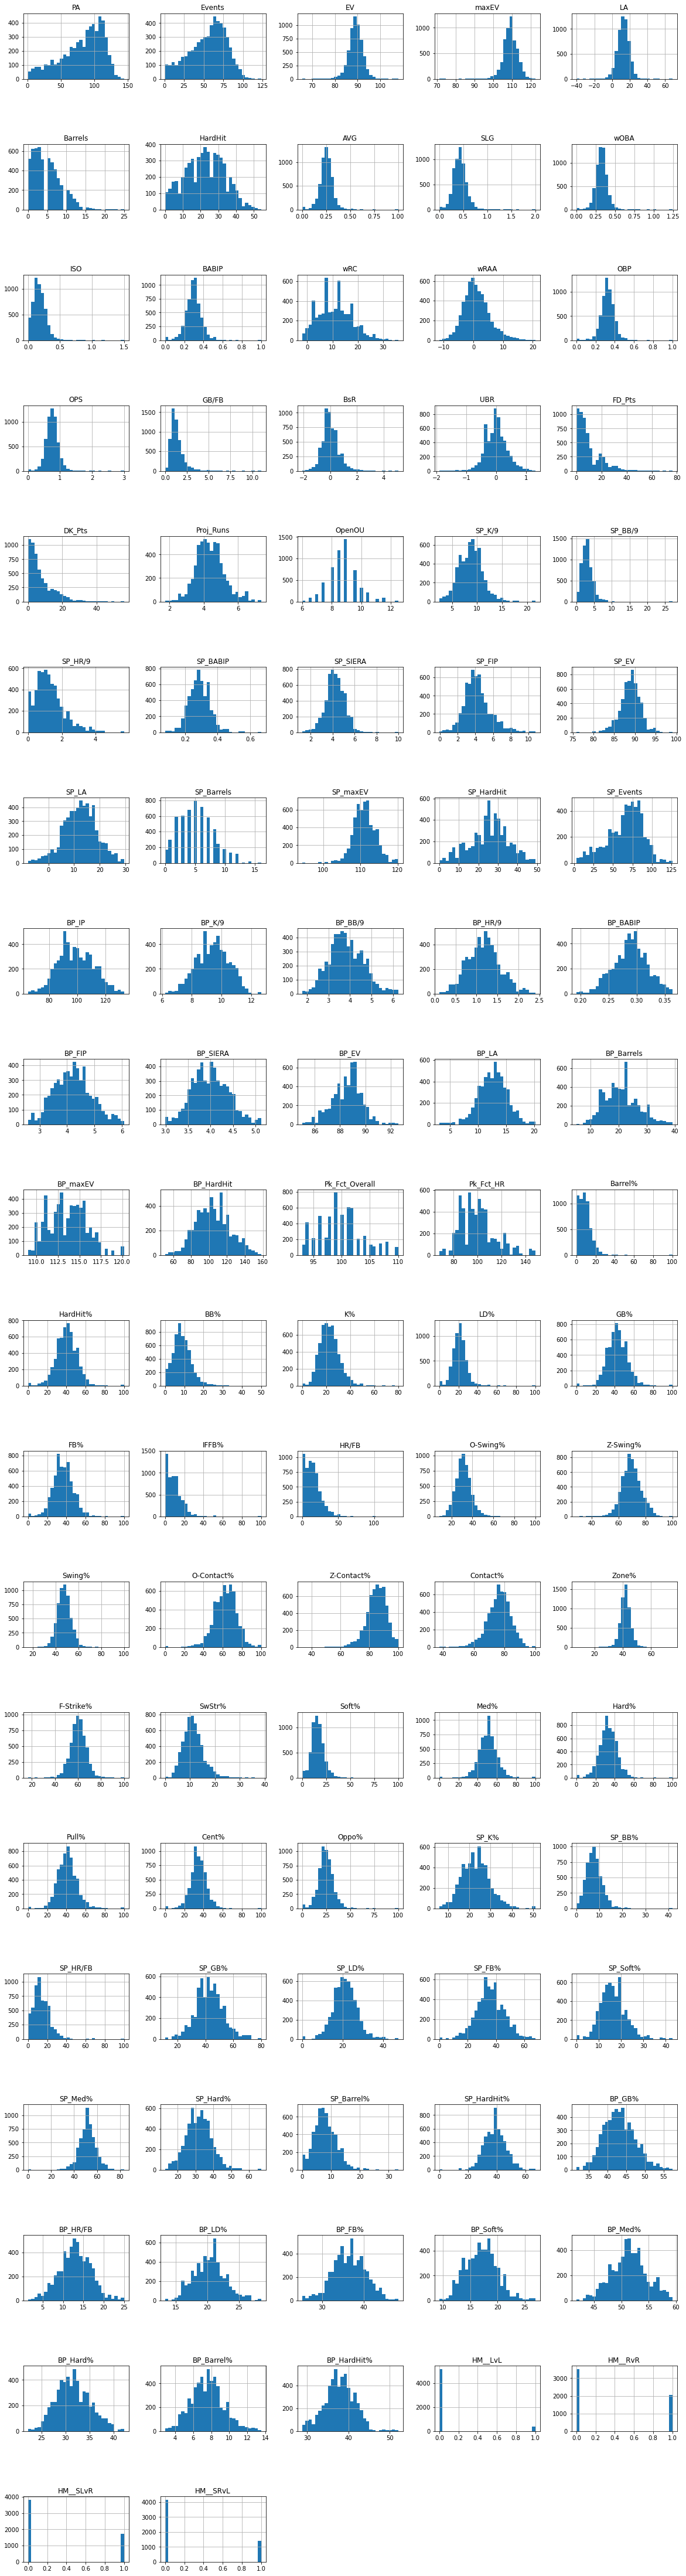

In [956]:
main_df.hist(layout=(20, 5), figsize=(20,80), bins = 30)
plt.subplots_adjust(hspace=1)
plt.show()

# Checking correlations
Even though we added stats-against for pitchers, we still have no correlations stronger than .1 in relationship to our target variables. However, the rankings of these correlations make intuitive sense. Barrels and Hard-Hit balls at the top and ground-ball and soft-contact indicators at the bottom.

In [957]:
main_df_corr = main_df.corr()

In [958]:
main_df_corr_sorted = main_df_corr.unstack().sort_values(ascending = False)

In [959]:
main_df_corr_sorted.loc['FD_Pts']

FD_Pts            1.000000
DK_Pts            0.996078
Barrels           0.104549
HardHit           0.100386
wRC               0.097429
maxEV             0.086962
Proj_Runs         0.085950
EV                0.085774
PA                0.084987
HardHit%          0.083078
Hard%             0.075074
wOBA              0.074510
OPS               0.073619
wRAA              0.073393
Events            0.069565
SLG               0.068992
OBP               0.067074
Barrel%           0.063574
ISO               0.062851
Pk_Fct_Overall    0.056577
OpenOU            0.056372
BP_SIERA          0.053034
AVG               0.051691
BB%               0.049200
HR/FB             0.048893
Pk_Fct_HR         0.047477
BP_Hard%          0.045674
BP_FIP            0.044212
BP_EV             0.043001
BsR               0.040375
BP_HardHit%       0.036339
BABIP             0.035428
BP_HardHit        0.034974
SP_EV             0.034734
BP_BB/9           0.033078
LA                0.032484
Z-Swing%          0.032225
S

In [710]:
main_df_corr_sorted.loc['DK_Pts']

DK_Pts            1.000000
FD_Pts            0.996078
HardHit           0.102281
Barrels           0.099688
wRC               0.096582
PA                0.087034
Proj_Runs         0.083168
maxEV             0.082652
EV                0.081176
HardHit%          0.079542
Events            0.074024
wOBA              0.072424
OPS               0.071282
Hard%             0.070433
wRAA              0.070401
OBP               0.066372
SLG               0.066088
ISO               0.056604
Barrel%           0.056459
OpenOU            0.056312
Pk_Fct_Overall    0.056090
AVG               0.054935
BP_SIERA          0.050575
BP_Hard%          0.045112
BsR               0.044596
Pk_Fct_HR         0.044401
BP_EV             0.042821
BB%               0.042103
HR/FB             0.042073
BP_FIP            0.041986
BABIP             0.039292
BP_HardHit%       0.035764
BP_HardHit        0.034836
Z-Swing%          0.034510
SP_EV             0.033412
SP_BABIP          0.031586
BP_BB/9           0.028966
L

# Train-test split
First we find the indexes of our target variables (remember there are two, FanDuel points and DraftKings points, so we'll have to do two train-test splits). Then we'll take 'Date' and 'Name' out of the column list and that will be the features list for our X variable.<br>
Finally, we use the StandardScaler.

In [964]:
main_df.columns.get_loc('FD_Pts')

21

In [965]:
main_df.columns.get_loc('DK_Pts')

22

In [966]:
main_df.columns

Index(['Date', 'Name', 'PA', 'Events', 'EV', 'maxEV', 'LA', 'Barrels',
       'HardHit', 'AVG', 'SLG', 'wOBA', 'ISO', 'BABIP', 'wRC', 'wRAA', 'OBP',
       'OPS', 'GB/FB', 'BsR', 'UBR', 'FD_Pts', 'DK_Pts', 'Proj_Runs', 'OpenOU',
       'SP_K/9', 'SP_BB/9', 'SP_HR/9', 'SP_BABIP', 'SP_SIERA', 'SP_FIP',
       'SP_EV', 'SP_LA', 'SP_Barrels', 'SP_maxEV', 'SP_HardHit', 'SP_Events',
       'BP_IP', 'BP_K/9', 'BP_BB/9', 'BP_HR/9', 'BP_BABIP', 'BP_FIP',
       'BP_SIERA', 'BP_EV', 'BP_LA', 'BP_Barrels', 'BP_maxEV', 'BP_HardHit',
       'Pk_Fct_Overall', 'Pk_Fct_HR', 'Barrel%', 'HardHit%', 'BB%', 'K%',
       'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'O-Swing%', 'Z-Swing%', 'Swing%',
       'O-Contact%', 'Z-Contact%', 'Contact%', 'Zone%', 'F-Strike%', 'SwStr%',
       'Soft%', 'Med%', 'Hard%', 'Pull%', 'Cent%', 'Oppo%', 'SP_K%', 'SP_BB%',
       'SP_HR/FB', 'SP_GB%', 'SP_LD%', 'SP_FB%', 'SP_Soft%', 'SP_Med%',
       'SP_Hard%', 'SP_Barrel%', 'SP_HardHit%', 'BP_GB%', 'BP_HR/FB', 'BP_LD%',
       'B

In [974]:
features = ['PA', 'Events', 'EV', 'maxEV', 'LA', 'Barrels', \
            'HardHit', 'AVG', 'SLG', 'wOBA', 'ISO', 'BABIP', 'wRC', 'wRAA', 'OBP',\
            'OPS', 'GB/FB', 'BsR', 'UBR', 'Proj_Runs', 'OpenOU',\
            'SP_K/9', 'SP_BB/9', 'SP_HR/9', 'SP_BABIP', 'SP_SIERA', 'SP_FIP',\
            'SP_EV', 'SP_LA', 'SP_Barrels', 'SP_maxEV', 'SP_HardHit', 'SP_Events',\
            'BP_IP', 'BP_K/9', 'BP_BB/9', 'BP_HR/9', 'BP_BABIP', 'BP_FIP',\
            'BP_SIERA', 'BP_EV', 'BP_LA', 'BP_Barrels', 'BP_maxEV', 'BP_HardHit',\
            'Pk_Fct_Overall', 'Pk_Fct_HR', 'Barrel%', 'HardHit%', 'BB%', 'K%',\
            'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'O-Swing%', 'Z-Swing%', 'Swing%',\
            'O-Contact%', 'Z-Contact%', 'Contact%', 'Zone%', 'F-Strike%', 'SwStr%',\
            'Soft%', 'Med%', 'Hard%', 'Pull%', 'Cent%', 'Oppo%', 'SP_K%', 'SP_BB%',\
            'SP_HR/FB', 'SP_GB%', 'SP_LD%', 'SP_FB%', 'SP_Soft%', 'SP_Med%',\
            'SP_Hard%', 'SP_Barrel%', 'SP_HardHit%', 'BP_GB%', 'BP_HR/FB', 'BP_LD%',\
            'BP_FB%', 'BP_Soft%', 'BP_Med%', 'BP_Hard%', 'BP_Barrel%',\
            'BP_HardHit%', 'HM__LvL', 'HM__RvR', 'HM__SLvR', 'HM__SRvL']

In [975]:
X = main_df[features]

In [981]:
y_FD = main_df.FD_Pts
y_DK = main_df.DK_Pts

In [982]:
X_train, X_test, y_FD_train, y_FD_test = train_test_split(X, y_FD, test_size = 0.25, random_state = 42)
X_train, X_test, y_DK_train, y_DK_test = train_test_split(X, y_DK, test_size = 0.25, random_state = 42)

In [983]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [984]:
X_train = scaler.fit_transform(X_train)

In [985]:
X_test = scaler.transform(X_test)